In [1]:
root =  "/home/brainmappinglab/Desktop/PROJECTS/Glioblastoma-TractDensity_Surival-Prognosis" # "D:\JoanFR_Sano"
MNI_DIR = "/home/brainmappinglab/Desktop/PROJECTS/MNI_ICBM_2009b_NLIN_ASYM" # "C:/Users/user/Documents/Data/MNI"
fmt = "svg"
dpi = 300
stream_th = 0

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
import matplotlib.patches as patches
from tqdm import tqdm

from scipy.stats import ttest_ind, zscore, chi2

import statsmodels.api as sm
from statsmodels.duration.hazard_regression import PHReg

from sksurv.linear_model import CoxPHSurvivalAnalysis

from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    GridSearchCV, KFold, RepeatedKFold, RepeatedStratifiedKFold, cross_validate
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, balanced_accuracy_score

In [3]:
figs_folder = os.path.join(root,"Relationships-features_anatomy-morphology")
daysXmonth = 365/12
voxel_size = (0.5**3) * (1/1000) # 0.5 (mm³/voxel) X 0.001 (cm³/mm³)   

os.makedirs(figs_folder, exist_ok=True) 

# Data

In [4]:
root_ucsf = os.path.join(root,"Glioblastoma_UCSF-PDGM_v3-20230111")
TDstats_ucsf = pd.read_csv(os.path.join(root_ucsf, f"TDMaps_Grade-IV/demographics-TDMaps_streamTH-{stream_th}.csv"))
morphology_ucsf = pd.read_csv(os.path.join(root_ucsf, f"TDMaps_Grade-IV/morphology-tissues.csv"))

TDstats_ucsf = TDstats_ucsf.loc[TDstats_ucsf["Final pathologic diagnosis (WHO 2021)"]=="Glioblastoma  IDH-wildtype"] 
TDstats_ucsf = TDstats_ucsf.loc[TDstats_ucsf["OS"].fillna('unknown')!='unknown']
morphology_ucsf = morphology_ucsf.loc[morphology_ucsf["Final pathologic diagnosis (WHO 2021)"]=="Glioblastoma  IDH-wildtype"] 
morphology_ucsf = morphology_ucsf.loc[morphology_ucsf["OS"].fillna('unknown')!='unknown']

common_cols = ['ID', 'Sex', 'Age at MRI', 'WHO CNS Grade', 
       'Final pathologic diagnosis (WHO 2021)', 'MGMT status', 'MGMT index',
       '1p/19q', 'IDH', '1-dead 0-alive', 'OS', 'EOR',
       'Biopsy prior to imaging', 'BraTS21 ID', 'BraTS21 Segmentation Cohort',
       'BraTS21 MGMT Cohort', '# Labels'
]
ucsf = pd.merge(TDstats_ucsf, morphology_ucsf, on=common_cols)

print(ucsf["1-dead 0-alive"].value_counts().sum())
censored = (ucsf["1-dead 0-alive"]==0).sum()
all_ucsf = ucsf["1-dead 0-alive"].value_counts().sum()
print(f"Precentage of censoring: {round(100*censored/all_ucsf,2)}%")

367
Precentage of censoring: 39.24%


In [5]:
root_upenn = os.path.join(root,"Glioblastoma_UPENN-GBM_v2-20221024")
TDstats_upenn = pd.read_csv(os.path.join(root_upenn, f"TDMaps_IDH1-WT/demographics-TDMaps_streamTH-{stream_th}.csv"))
morphology_upenn = pd.read_csv(os.path.join(root_upenn, f"TDMaps_IDH1-WT/morphology-tissues.csv"))
    
common_cols = ["ID", "Gender", "Age_at_scan_years", "Survival_from_surgery_days_UPDATED", "Survival_Status", "MGMT", "KPS", "GTR_over90percent"]
upenn = pd.merge(TDstats_upenn, morphology_upenn, on=common_cols)

print(upenn["Survival_Status"].value_counts().sum())
censored = (upenn["Survival_Status"]==0).sum()
all_upenn = upenn["Survival_Status"].value_counts().sum()
print(f"Precentage of censoring: {round(100*censored/all_upenn,2)}%")

496
Precentage of censoring: 2.82%


In [6]:
z_transform = 0
cohort_ids = [0, 1]
mgmt_ucsf = {"negative": 1, "indeterminate": 2, "positive": 3, np.nan: np.nan}
EOR_ucsf = {"biopsy": 1, "STR": 2, "GTR": 3, "Not Available": np.nan}

mgmt_upenn = {"Unmethylated": 1, "Indeterminate": 2, "Methylated": 3, "Not Available": np.nan}
EOR_upenn = {"N": 2, "Y": 3, "Not Available": np.nan}

# UCSF
df_ucsf = pd.DataFrame({
    "ID": ucsf["ID"].values,
    "male": [1 if s=="M" else 0 for s in ucsf["Sex"].values],
    "female": [1 if s=="F" else 0 for s in ucsf["Sex"].values],
    "sex": [1 if s=="M" else 2 for s in ucsf["Sex"].values],
    "age": ucsf["Age at MRI"].values,
    "site": np.zeros(len(ucsf), dtype=int) + cohort_ids[0],  # UCSF = 0
    "volume": ucsf["Whole tumor size (voxels)"].values * voxel_size,
    "ltdi": ucsf["Whole lesion TDMap"].values,
    "tdi": ucsf["Whole TDMap"].values,
    "OS": ucsf["OS"].values,
    "status": ucsf["1-dead 0-alive"].values,
    "EOR": [EOR_ucsf[eor] for eor in ucsf["EOR"].values],
    "mgmt": [mgmt_ucsf[mgmt] for mgmt in ucsf["MGMT status"].values]
})

# UPENN
df_upenn = pd.DataFrame({
    "ID": upenn["ID"].values,
    "male": [1 if s=="M" else 0 for s in upenn["Gender"].values],
    "female": [1 if s=="F" else 0 for s in upenn["Gender"].values],
    "sex": [1 if s=="M" else 2 for s in upenn["Gender"].values],
    "age": upenn["Age_at_scan_years"].values,
    "site": np.zeros(len(upenn), dtype=int) + cohort_ids[1],  # UPENN = 1
    "volume": upenn["Whole tumor size (voxels)"].values * voxel_size,
    "ltdi": upenn["Whole lesion TDMap"].values,
    "tdi": upenn["Whole TDMap"].values,
    "OS": upenn["Survival_from_surgery_days_UPDATED"].values,
    "status": upenn["Survival_Status"].values,
    "EOR": [EOR_upenn[eor] for eor in upenn["GTR_over90percent"].values],
    "mgmt": [mgmt_upenn[mgmt] for mgmt in upenn["MGMT"].values]
})

DATA = pd.concat([df_ucsf, df_upenn], axis=0, ignore_index=True)

if z_transform == 1:
    for col in ["age", "volume", "ltdi", "tdi"]:
        DATA[col] = zscore(DATA[col])

# Tract density markers

### Including the volume (morphology)

In [7]:
covariates = ["ltdi","tdi","volume"]
data = DATA[covariates+["site","OS","status"]]

cox_site = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = cox_site.fit()
site_effect = results_site.params[np.array(cox_site.exog_names)=='site']
print(results_site.summary(yname="Overall survival (days)", xname=covariates+["site"], title=f"Including the effect of cohort/site (LLF={round(results_site.llf,3)})"))
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
cox_desite = PHReg(
    data["OS"] * np.exp(site_effect*data["site"]),
    data[covariates],
    status=data["status"]
)
results_desite = cox_desite.fit()
print(results_desite.summary(yname="Overall survival (days)", xname=covariates, title=f"Correcting for the effect of cohort/site (LLF = {round(results_desite.llf,3)})"))

    Including the effect of cohort/site (LLF=-4075.664)
Model:              PH Reg                  Sample size: 863
Dependent variable: Overall survival (days) Num. events: 705
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
ltdi    0.3427    0.0608 1.4088  5.6370 0.0000 1.2505 1.5871
tdi    -0.0026    0.0014 0.9974 -1.7745 0.0760 0.9946 1.0003
volume -0.0069    0.0014 0.9932 -4.7835 0.0000 0.9904 0.9960
site    0.2593    0.0818 1.2960  3.1688 0.0015 1.1040 1.5215
Confidence intervals are for the hazard ratios
++++++++++++++++++++++++++++++++++++++++++++++++++++++
 Correcting for the effect of cohort/site (LLF = -4061.058)
Model:              PH Reg                  Sample size: 863
Dependent variable: Overall survival (days) Num. events: 705
Ties:               Breslow                       

In [8]:
X = DATA["site"]
X = sm.add_constant(X)  
model = sm.OLS(DATA["tdi"], X).fit()
tdi_corrected = DATA["tdi"] - (model.params["site"] * DATA["site"]) 
group_0 = tdi_corrected[DATA["site"] == 0]
group_1 = tdi_corrected[DATA["site"] == 1]
t_stat, p_value = ttest_ind(group_0, group_1)
if p_value<=0.05:
    print("WARNING! The effect of site was not removed for the TDI")
else:
    DATA.loc[:,"tdi_corrected"] = tdi_corrected

X = DATA["site"] 
X = sm.add_constant(X)  
model = sm.OLS(DATA["volume"], X).fit()
volume_corrected = DATA["volume"] - (model.params["site"] * DATA["site"]) 
group_0 = volume_corrected[DATA["site"] == 0]
group_1 = volume_corrected[DATA["site"] == 1]
t_stat, p_value = ttest_ind(group_0, group_1)
if p_value<=0.05:
    print("WARNING! The effect of site was not removed for the volume")
else:
    DATA.loc[:,"volume_corrected"] = volume_corrected

covariates = ["ltdi","tdi_corrected", "volume_corrected"]
dataf = DATA[covariates+["site","OS","status"]]
cox_site2 = PHReg(
    dataf["OS"],
    dataf[covariates+["site"]],
    status=dataf["status"]
)
results_site2 = cox_site2.fit()
site2_effect = results_site2.params[np.array(cox_site2.exog_names)=='site']
print(results_site2.summary(yname="Overall survival (days)", xname=covariates+["site"], title=f"Including the effect of cohort/site (LLF={round(results_site2.llf,3)})"))    
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
cox_desite2 = PHReg(
    dataf["OS"] * np.exp(site2_effect*dataf["site"]),
    dataf[covariates],
    status=dataf["status"]
)
results_desite2 = cox_desite2.fit()
print(results_desite.summary(yname="Overall survival (days)", xname=covariates, title=f"Correcting for the effect of cohort/site (LLF = {round(results_desite2.llf,3)})"))

         Including the effect of cohort/site (LLF=-4075.664)
Model:                  PH Reg                     Sample size:    863
Dependent variable:     Overall survival (days)    Num. events:    705
Ties:                   Breslow                                       
----------------------------------------------------------------------
                  log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
----------------------------------------------------------------------
ltdi              0.3427    0.0608 1.4088  5.6370 0.0000 1.2505 1.5871
tdi_corrected    -0.0026    0.0014 0.9974 -1.7745 0.0760 0.9946 1.0003
volume_corrected -0.0069    0.0014 0.9932 -4.7835 0.0000 0.9904 0.9960
site              0.3368    0.0821 1.4005  4.1009 0.0000 1.1922 1.6451
Confidence intervals are for the hazard ratios
++++++++++++++++++++++++++++++++++++++++++++++++++++++
      Correcting for the effect of cohort/site (LLF = -4055.23)
Model:                  PH Reg                     Sample size:

### Excluding the volume (morphology)

In [9]:
covariates = ["ltdi","tdi"]
data = DATA[covariates+["site","OS","status"]]

cox_site = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = cox_site.fit()
site_effect = results_site.params[np.array(cox_site.exog_names)=='site']
print(results_site.summary(yname="Overall survival (days)", xname=covariates+["site"], title=f"Including the effect of cohort/site (LLF={round(results_site.llf,3)})"))
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
cox_desite = PHReg(
    data["OS"] * np.exp(site_effect*data["site"]),
    data[covariates],
    status=data["status"]
)
results_desite = cox_desite.fit()
print(results_desite.summary(yname="Overall survival (days)", xname=covariates, title=f"Correcting for the effect of cohort/site (LLF = {round(results_desite.llf,3)})"))

    Including the effect of cohort/site (LLF=-4086.864)
Model:              PH Reg                  Sample size: 863
Dependent variable: Overall survival (days) Num. events: 705
Ties:               Breslow                                 
------------------------------------------------------------
         log HR log HR SE   HR     t    P>|t|  [0.025 0.975]
------------------------------------------------------------
ltdi     0.0686    0.0241 1.0710 2.8428 0.0045 1.0215 1.1228
tdi      0.0024    0.0010 1.0024 2.2574 0.0240 1.0003 1.0044
site     0.2816    0.0817 1.3253 3.4483 0.0006 1.1293 1.5553
Confidence intervals are for the hazard ratios
++++++++++++++++++++++++++++++++++++++++++++++++++++++
 Correcting for the effect of cohort/site (LLF = -4070.782)
Model:              PH Reg                  Sample size: 863
Dependent variable: Overall survival (days) Num. events: 705
Ties:               Breslow                                 
--------------------------------------------------

### Equivalence between L-TDI and TDI + Volume

In [10]:
covariates = ["ltdi"]
data = DATA[covariates+["site","OS","status"]]

cox_site = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = cox_site.fit()
site_effect = results_site.params[np.array(cox_site.exog_names)=='site']
print(results_site.summary(yname="Overall survival (days)", xname=covariates+["site"], title=f"Including the effect of cohort/site (LLF={round(results_site.llf,3)})"))
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
cox_desite = PHReg(
    data["OS"] * np.exp(site_effect*data["site"]),
    data[covariates],
    status=data["status"]
)
results_desite = cox_desite.fit()
print(results_desite.summary(yname="Overall survival (days)", xname=covariates, title=f"Correcting for the effect of cohort/site (LLF = {round(results_desite.llf,3)})"))

LLF_LTDI = cox_desite.loglike(results_desite.params)

    Including the effect of cohort/site (LLF=-4089.365)
Model:              PH Reg                  Sample size: 863
Dependent variable: Overall survival (days) Num. events: 705
Ties:               Breslow                                 
------------------------------------------------------------
         log HR log HR SE   HR     t    P>|t|  [0.025 0.975]
------------------------------------------------------------
ltdi     0.0932    0.0212 1.0977 4.3989 0.0000 1.0531 1.1443
site     0.2881    0.0816 1.3339 3.5294 0.0004 1.1367 1.5653
Confidence intervals are for the hazard ratios
++++++++++++++++++++++++++++++++++++++++++++++++++++++
 Correcting for the effect of cohort/site (LLF = -4072.74)
Model:              PH Reg                  Sample size: 863
Dependent variable: Overall survival (days) Num. events: 705
Ties:               Breslow                                 
------------------------------------------------------------
         log HR log HR SE   HR     t    P>|t|  [0.0

In [11]:
covariates = ["tdi","volume"]
data = DATA[covariates+["site","OS","status"]]

cox_site = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = cox_site.fit()
site_effect = results_site.params[np.array(cox_site.exog_names)=='site']
print(results_site.summary(yname="Overall survival (days)", xname=covariates+["site"], title=f"Including the effect of cohort/site (LLF={round(results_site.llf,3)})"))
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
cox_desite = PHReg(
    data["OS"] * np.exp(site_effect*data["site"]),
    data[covariates],
    status=data["status"]
)
results_desite = cox_desite.fit()
print(results_desite.summary(yname="Overall survival (days)", xname=covariates, title=f"Correcting for the effect of cohort/site (LLF = {round(results_desite.llf,3)})"))

LLF_TDI = cox_desite.loglike(results_desite.params)

     Including the effect of cohort/site (LLF=-4090.51)
Model:              PH Reg                  Sample size: 863
Dependent variable: Overall survival (days) Num. events: 705
Ties:               Breslow                                 
------------------------------------------------------------
         log HR log HR SE   HR     t    P>|t|  [0.025 0.975]
------------------------------------------------------------
tdi      0.0036    0.0009 1.0036 3.9618 0.0001 1.0018 1.0054
volume   0.0005    0.0006 1.0005 0.8421 0.3997 0.9994 1.0016
site     0.2793    0.0817 1.3222 3.4182 0.0006 1.1265 1.5518
Confidence intervals are for the hazard ratios
++++++++++++++++++++++++++++++++++++++++++++++++++++++
 Correcting for the effect of cohort/site (LLF = -4074.687)
Model:              PH Reg                  Sample size: 863
Dependent variable: Overall survival (days) Num. events: 705
Ties:               Breslow                                 
--------------------------------------------------

In [12]:
print("In all the following results, the effect of site was removed!")
print()
print(f"Log-likelihood of the model with the L-TDI as a covariate: {LLF_LTDI}")
print(f"Log-likelihood of the model with the TDI as a covariate: {LLF_TDI}")
print()

DF = 1 # The full model contains 1 more parameter than the reduced model
chi2_TDI_better = - 2 * (LLF_LTDI - LLF_TDI)
chi2_LTDI_better = - 2 * (LLF_TDI - LLF_LTDI)
p_value_TDI_better = 1 - chi2.cdf(chi2_TDI_better, df=DF)
p_value_LTDI_better = 1 - chi2.cdf(chi2_LTDI_better, df=DF)

print(f"P-value supposing that the TDI-based model performs better: {p_value_TDI_better:.4f}")
print(f"P-value supposing that the LTDI-based model performs better: {p_value_LTDI_better:.4f}")

In all the following results, the effect of site was removed!

Log-likelihood of the model with the L-TDI as a covariate: -4072.7395308079963
Log-likelihood of the model with the TDI as a covariate: -4074.686683452763

P-value supposing that the TDI-based model performs better: 1.0000
P-value supposing that the LTDI-based model performs better: 0.0485


# Cox proportional Hazard models

## Missing value strategy $\to$ drop NaNs

### One hot encoding for Sex

In [13]:
covariates = ["male", "female", "age", "ltdi", "mgmt","EOR"]
data = DATA[covariates+["site","OS","status"]].dropna()

cox_site = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = cox_site.fit()
site_effect = results_site.params[np.array(cox_site.exog_names)=='site']
print(results_site.summary(yname="Overall survival (days)", xname=covariates+["site"], title=f"Including the effect of cohort/site (LLF={round(results_site.llf,3)})"))
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
cox_desite = PHReg(
    data["OS"] * np.exp(site_effect*data["site"]),
    data[covariates],
    status=data["status"]
)
results_desite = cox_desite.fit()
print(results_desite.summary(yname="Overall survival (days)", xname=covariates, title=f"Correcting for the effect of cohort/site (LLF = {round(results_desite.llf,3)})"))

/home/brainmappinglab/anaconda3/envs/glioblastomas/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


      Including the effect of cohort/site (LLF=-2519.538)
Model:               PH Reg                   Sample size:  615
Dependent variable:  Overall survival (days)  Num. events:  472
Ties:                Breslow                                   
---------------------------------------------------------------
        log HR  log HR SE     HR      t    P>|t|  [0.025 0.975]
---------------------------------------------------------------
male    0.0269 2304018.4695 1.0273  0.0000 1.0000 0.0000    inf
female -0.0270 2304018.4695 0.9734 -0.0000 1.0000 0.0000    inf
age     0.0274       0.0045 1.0278  6.0957 0.0000 1.0188 1.0369
ltdi    0.0714       0.0256 1.0740  2.7853 0.0053 1.0214 1.1294
mgmt   -0.3242       0.0499 0.7231 -6.5003 0.0000 0.6557 0.7973
EOR    -0.5565       0.0838 0.5732 -6.6408 0.0000 0.4864 0.6755
site    0.1091       0.0959 1.1153  1.1380 0.2551 0.9242 1.3459
Confidence intervals are for the hazard ratios
++++++++++++++++++++++++++++++++++++++++++++++++++++++
  Correc

/home/brainmappinglab/anaconda3/envs/glioblastomas/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/brainmappinglab/anaconda3/envs/glioblastomas/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Categorical encoding for Sex including L-TDI as a covariate of interest

In [14]:
covariates = ["sex", "age", "ltdi", "mgmt", "EOR"]
data = DATA[covariates+["site","OS","status"]].dropna()

cox_site = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = cox_site.fit()
site_effect = results_site.params[np.array(cox_site.exog_names)=='site']
print(results_site.summary(yname="Overall survival (days)", xname=covariates+["site"], title=f"Including the effect of cohort/site (LLF={round(results_site.llf,3)})"))
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
cox_desite = PHReg(
    data["OS"] * np.exp(site_effect*data["site"]),
    data[covariates],
    status=data["status"]
)
results_desite = cox_desite.fit()
print(results_desite.summary(yname="Overall survival (days)", xname=covariates, title=f"Correcting for the effect of cohort/site (LLF = {round(results_desite.llf,3)})"))

LLF_with_LTDI = cox_desite.loglike(results_desite.params)

    Including the effect of cohort/site (LLF=-2519.538)
Model:              PH Reg                  Sample size: 615
Dependent variable: Overall survival (days) Num. events: 472
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
sex    -0.0539    0.0966 0.9475 -0.5580 0.5769 0.7841 1.1450
age     0.0274    0.0045 1.0278  6.0957 0.0000 1.0188 1.0369
ltdi    0.0714    0.0256 1.0740  2.7853 0.0053 1.0214 1.1294
mgmt   -0.3242    0.0499 0.7231 -6.5003 0.0000 0.6557 0.7973
EOR    -0.5565    0.0838 0.5732 -6.6408 0.0000 0.4864 0.6755
site    0.1091    0.0959 1.1153  1.1380 0.2551 0.9242 1.3459
Confidence intervals are for the hazard ratios
++++++++++++++++++++++++++++++++++++++++++++++++++++++
 Correcting for the effect of cohort/site (LLF = -2515.517)
Model:              PH Reg                  Sample

### Categorical encoding for Sex including TDI as a covariate of interest

In [15]:
covariates = ["sex", "age", "tdi", "mgmt", "EOR"]
data = DATA[covariates+["site","OS","status"]].dropna()

cox_site = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = cox_site.fit()
site_effect = results_site.params[np.array(cox_site.exog_names)=='site']
print(results_site.summary(yname="Overall survival (days)", xname=covariates+["site"], title=f"Including the effect of cohort/site (LLF={round(results_site.llf,3)})"))
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
cox_desite = PHReg(
    data["OS"] * np.exp(site_effect*data["site"]),
    data[covariates],
    status=data["status"]
)
results_desite = cox_desite.fit()
print(results_desite.summary(yname="Overall survival (days)", xname=covariates, title=f"Correcting for the effect of cohort/site (LLF = {round(results_desite.llf,3)})"))

LLF_with_TDI = cox_desite.loglike(results_desite.params)

     Including the effect of cohort/site (LLF=-2520.87)
Model:              PH Reg                  Sample size: 615
Dependent variable: Overall survival (days) Num. events: 472
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
sex    -0.0417    0.0966 0.9591 -0.4322 0.6656 0.7938 1.1589
age     0.0269    0.0045 1.0273  5.9835 0.0000 1.0183 1.0364
tdi     0.0026    0.0012 1.0026  2.2444 0.0248 1.0003 1.0049
mgmt   -0.3297    0.0501 0.7192 -6.5790 0.0000 0.6519 0.7934
EOR    -0.5680    0.0834 0.5667 -6.8101 0.0000 0.4812 0.6673
site    0.0898    0.0958 1.0940  0.9379 0.3483 0.9067 1.3200
Confidence intervals are for the hazard ratios
++++++++++++++++++++++++++++++++++++++++++++++++++++++
 Correcting for the effect of cohort/site (LLF = -2517.882)
Model:              PH Reg                  Sample

In [16]:
## FOR COMPLETENESS LET'S BUILD THE MODEL WITH THE CORRECTED TDI VALUES
covariates = ["sex", "age", "tdi_corrected", "mgmt", "EOR"]
data = DATA[covariates+["site","OS","status"]].dropna()

cox_site = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = cox_site.fit()
site_effect = results_site.params[np.array(cox_site.exog_names)=='site']
print(results_site.summary(yname="Overall survival (days)", xname=covariates+["site"], title=f"Including the effect of cohort/site (LLF={round(results_site.llf,3)})"))
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
cox_desite = PHReg(
    data["OS"] * np.exp(site_effect*data["site"]),
    data[covariates],
    status=data["status"]
)
results_desite = cox_desite.fit()
print(results_desite.summary(yname="Overall survival (days)", xname=covariates, title=f"Correcting for the effect of cohort/site (LLF = {round(results_desite.llf,3)})"))

LLF_with_TDI_corrected = cox_desite.loglike(results_desite.params)

        Including the effect of cohort/site (LLF=-2520.87)
Model:                 PH Reg                    Sample size:   615
Dependent variable:    Overall survival (days)   Num. events:   472
Ties:                  Breslow                                     
-------------------------------------------------------------------
               log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
-------------------------------------------------------------------
sex           -0.0417    0.0966 0.9591 -0.4322 0.6656 0.7938 1.1589
age            0.0269    0.0045 1.0273  5.9835 0.0000 1.0183 1.0364
tdi_corrected  0.0026    0.0012 1.0026  2.2444 0.0248 1.0003 1.0049
mgmt          -0.3297    0.0501 0.7192 -6.5790 0.0000 0.6519 0.7934
EOR           -0.5680    0.0834 0.5667 -6.8101 0.0000 0.4812 0.6673
site           0.1063    0.0960 1.1121  1.1073 0.2681 0.9214 1.3423
Confidence intervals are for the hazard ratios
++++++++++++++++++++++++++++++++++++++++++++++++++++++
    Correcting for the 

### Categorical encoding for Sex including TDI and volume as a covariate of interest

In [17]:
covariates = ["sex", "age", "tdi", "volume", "mgmt", "EOR"]
data = DATA[covariates+["site","OS","status"]].dropna()

cox_site = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = cox_site.fit()
site_effect = results_site.params[np.array(cox_site.exog_names)=='site']
print(results_site.summary(yname="Overall survival (days)", xname=covariates+["site"], title=f"Including the effect of cohort/site (LLF={round(results_site.llf,3)})"))
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
cox_desite = PHReg(
    data["OS"] * np.exp(site_effect*data["site"]),
    data[covariates],
    status=data["status"]
)
results_desite = cox_desite.fit()
print(results_desite.summary(yname="Overall survival (days)", xname=covariates, title=f"Correcting for the effect of cohort/site (LLF = {round(results_desite.llf,3)})"))

LLF_with_TDI_volume = cox_desite.loglike(results_desite.params)

     Including the effect of cohort/site (LLF=-2520.01)
Model:              PH Reg                  Sample size: 615
Dependent variable: Overall survival (days) Num. events: 472
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
sex    -0.0467    0.0965 0.9544 -0.4833 0.6289 0.7899 1.1532
age     0.0271    0.0045 1.0274  6.0028 0.0000 1.0184 1.0366
tdi     0.0025    0.0012 1.0025  2.0677 0.0387 1.0001 1.0048
volume  0.0009    0.0007 1.0009  1.3193 0.1871 0.9996 1.0023
mgmt   -0.3282    0.0500 0.7202 -6.5587 0.0000 0.6529 0.7944
EOR    -0.5664    0.0835 0.5676 -6.7819 0.0000 0.4819 0.6685
site    0.1019    0.0963 1.1073  1.0584 0.2899 0.9169 1.3372
Confidence intervals are for the hazard ratios
++++++++++++++++++++++++++++++++++++++++++++++++++++++
 Correcting for the effect of cohort/site (LLF = 

In [18]:
## FOR COMPLETENESS LET'S BUILD THE MODEL WITH THE CORRECTED TDI AND VOLUME VALUES
covariates = ["sex", "age", "tdi_corrected", "volume_corrected", "mgmt", "EOR"]
data = DATA[covariates+["site","OS","status"]].dropna()

cox_site = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = cox_site.fit()
site_effect = results_site.params[np.array(cox_site.exog_names)=='site']
print(results_site.summary(yname="Overall survival (days)", xname=covariates+["site"], title=f"Including the effect of cohort/site (LLF={round(results_site.llf,3)})"))
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
cox_desite = PHReg(
    data["OS"] * np.exp(site_effect*data["site"]),
    data[covariates],
    status=data["status"]
)
results_desite = cox_desite.fit()
print(results_desite.summary(yname="Overall survival (days)", xname=covariates, title=f"Correcting for the effect of cohort/site (LLF = {round(results_desite.llf,3)})"))

LLF_with_TDI_volume_corrected = cox_desite.loglike(results_desite.params)

          Including the effect of cohort/site (LLF=-2520.01)
Model:                  PH Reg                     Sample size:    615
Dependent variable:     Overall survival (days)    Num. events:    472
Ties:                   Breslow                                       
----------------------------------------------------------------------
                  log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
----------------------------------------------------------------------
sex              -0.0467    0.0965 0.9544 -0.4833 0.6289 0.7899 1.1532
age               0.0271    0.0045 1.0274  6.0028 0.0000 1.0184 1.0366
tdi_corrected     0.0025    0.0012 1.0025  2.0677 0.0387 1.0001 1.0048
volume_corrected  0.0009    0.0007 1.0009  1.3193 0.1871 0.9996 1.0023
mgmt             -0.3282    0.0500 0.7202 -6.5587 0.0000 0.6529 0.7944
EOR              -0.5664    0.0835 0.5676 -6.7819 0.0000 0.4819 0.6685
site              0.1050    0.0960 1.1108  1.0944 0.2738 0.9203 1.3407
Confidence inter

### Categorical encoding for Sex excluding tract density-based markers as covariates of interest

In [19]:
covariates = ["sex", "age", "mgmt", "EOR"]
data = DATA[covariates+["site","OS","status"]].dropna()

cox_site = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = cox_site.fit()
site_effect = results_site.params[np.array(cox_site.exog_names)=='site']
print(results_site.summary(yname="Overall survival (days)", xname=covariates+["site"], title=f"Including the effect of cohort/site (LLF={round(results_site.llf,3)})"))
print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
cox_desite = PHReg(
    data["OS"] * np.exp(site_effect*data["site"]),
    data[covariates],
    status=data["status"]
)
results_desite = cox_desite.fit()
print(results_desite.summary(yname="Overall survival (days)", xname=covariates, title=f"Correcting for the effect of cohort/site (LLF = {round(results_desite.llf,3)})"))

LLF_without_tracts = cox_desite.loglike(results_desite.params)

    Including the effect of cohort/site (LLF=-2523.403)
Model:              PH Reg                  Sample size: 615
Dependent variable: Overall survival (days) Num. events: 472
Ties:               Breslow                                 
------------------------------------------------------------
        log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
------------------------------------------------------------
sex    -0.0260    0.0961 0.9743 -0.2706 0.7867 0.8071 1.1762
age     0.0279    0.0045 1.0283  6.2460 0.0000 1.0194 1.0374
mgmt   -0.3248    0.0500 0.7227 -6.5001 0.0000 0.6553 0.7971
EOR    -0.5990    0.0824 0.5494 -7.2720 0.0000 0.4674 0.6456
site    0.0920    0.0957 1.0964  0.9619 0.3361 0.9089 1.3225
Confidence intervals are for the hazard ratios
++++++++++++++++++++++++++++++++++++++++++++++++++++++
 Correcting for the effect of cohort/site (LLF = -2520.329)
Model:              PH Reg                  Sample size: 614
Dependent variable: Overall survival (days) Num. e

### Comparing log-likelihoods

In [20]:
print("In all the following results, the effect of site was removed!")
print()
print(f"Log-likelihood of the model with the L-TDI as a covariate: {LLF_with_LTDI}")
print(f"Log-likelihood of the model with the TDI as a covariate: {LLF_with_TDI}")
print(f"Log-likelihood of the model with the corrected TDI as a covariate: {LLF_with_TDI_corrected}")
print(f"Log-likelihood of the model with the TDI and volume as a covariates: {LLF_with_TDI_volume}")
print(f"Log-likelihood of the model with the corrected TDI and volume as a covariates: {LLF_with_TDI_volume_corrected}")
print(f"Log-likelihood of the model without tract density-based markers as covariates: {LLF_without_tracts}")
print()

DF = 1 # The full model contains 1 more parameter than the reduced model
chi2_LTDI = - 2 * (LLF_without_tracts - LLF_with_LTDI)
chi2_TDI = - 2 * (LLF_without_tracts - LLF_with_TDI)
chi2_TDI_volume = -2 * (LLF_without_tracts - LLF_with_TDI_volume)
chi2_TDI_corrected = - 2 * (LLF_without_tracts - LLF_with_TDI_corrected)
chi2_TDI_volume_corrected = -2 * (LLF_without_tracts - LLF_with_TDI_volume_corrected)

chi2_TDI_better = - 2 * (LLF_with_LTDI - LLF_with_TDI)
chi2_LTDI_better = - 2 * (LLF_with_TDI - LLF_with_LTDI)
chi2_LTDI_better_corrected = - 2 * (LLF_with_TDI_corrected - LLF_with_LTDI)
chi2_LTDI_better_TDI_volume = - 2 * (LLF_with_TDI_volume - LLF_with_LTDI)
chi2_LTDI_better_TDI_volume_corrected = - 2 * (LLF_with_TDI_volume_corrected - LLF_with_LTDI)


p_value_LTDI = 1 - chi2.cdf(chi2_LTDI, df=DF)
p_value_TDI = 1 - chi2.cdf(chi2_TDI, df=DF)
p_value_TDI_volume = 1- chi2.cdf(chi2_TDI_volume, df=DF)
p_value_TDI_corrected = 1 - chi2.cdf(chi2_TDI_corrected, df=DF)
p_value_TDI_volume_corrected = 1- chi2.cdf(chi2_TDI_volume_corrected, df=DF)

p_value_TDI_better = 1 - chi2.cdf(chi2_TDI_better, df=DF)
p_value_LTDI_better = 1 - chi2.cdf(chi2_LTDI_better, df=DF)
p_value_LTDI_better_corrected = 1 - chi2.cdf(chi2_LTDI_better_corrected, df=DF)
p_value_LTDI_better_TDI_volume = 1 - chi2.cdf(chi2_LTDI_better_TDI_volume, df=DF)
p_value_LTDI_better_TDI_volume_corrected = 1 - chi2.cdf(chi2_LTDI_better_TDI_volume_corrected, df=DF)

print(f"P-value associated with the addition of the L-TDI covariate: {p_value_LTDI:.4f}")
print(f"P-value associated with the addition of the TDI covariate: {p_value_TDI:.4f}")
print(f"P-value associated with the addition of the TDI and volumes covariates: {p_value_TDI_volume:.4f}")
print(f"P-value associated with the addition of the corrected TDI covariate: {p_value_TDI_corrected:.4f}")
print(f"P-value associated with the addition of the corrected TDI and volumes covariates: {p_value_TDI_volume_corrected:.4f}")
print()
print(f"P-value supposing that the TDI-based model performs better: {p_value_TDI_better:.4f}")
print(f"P-value supposing that the LTDI-based model performs better than the TDI: {p_value_LTDI_better:.4f}")
print(f"P-value supposing that the corrected TDI-based model performs better than the L-TDI: {p_value_TDI_better:.4f}")
print(f"P-value supposing that the LTDI-based model performs better than the corrected TDI: {p_value_LTDI_better_corrected:.4f}")
print(f"P-value supposing that the LTDI-based model performs better than the joint TDI+volume: {p_value_LTDI_better_TDI_volume:.4f}")
print(f"P-value supposing that the LTDI-based model performs better than the joint corrected TDI+volume: {p_value_LTDI_better_TDI_volume_corrected:.4f}")

In all the following results, the effect of site was removed!

Log-likelihood of the model with the L-TDI as a covariate: -2515.516701314487
Log-likelihood of the model with the TDI as a covariate: -2517.88180502973
Log-likelihood of the model with the corrected TDI as a covariate: -2516.946690687074
Log-likelihood of the model with the TDI and volume as a covariates: -2516.469922711926
Log-likelihood of the model with the corrected TDI and volume as a covariates: -2516.1958260974543
Log-likelihood of the model without tract density-based markers as covariates: -2520.3290786006605

P-value associated with the addition of the L-TDI covariate: 0.0019
P-value associated with the addition of the TDI covariate: 0.0269
P-value associated with the addition of the TDI and volumes covariates: 0.0055
P-value associated with the addition of the corrected TDI covariate: 0.0093
P-value associated with the addition of the corrected TDI and volumes covariates: 0.0040

P-value supposing that the TDI-b

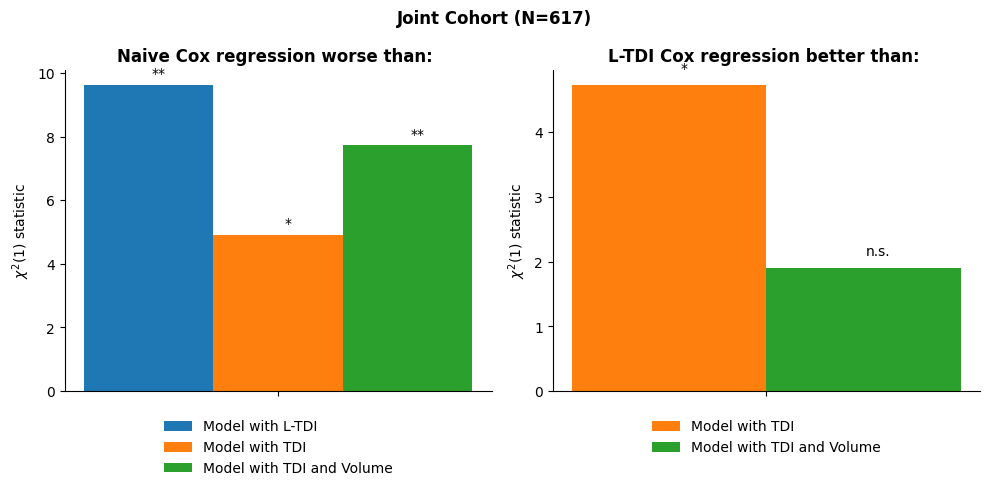

In [21]:
def get_significance_marker(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"  
    elif p < 0.05:
        return "*"  
    else:
        return "n.s." 
    
fig, ax = plt.subplots(1,2,figsize=(10, 5))
bar_width = 0.2
time_labels = [""]
x = np.arange(len(time_labels))

### Measuring the added value of tract density-based covariates
model_labels = ["Model with L-TDI", "Model with TDI", "Model with TDI and Volume"]
colors = ["tab:blue", "tab:orange", "tab:green"]
llrs = np.array([
    [chi2_LTDI, chi2_TDI, chi2_TDI_volume]
])
p_values = 1 - chi2.cdf(llrs, df=1)
for i in range(len(model_labels)):
    bars = ax[0].bar(x + i * bar_width, llrs[:, i], width=bar_width, label=model_labels[i], color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = get_significance_marker(p_values[j, i])
        ax[0].text(
            bar.get_x() + bar.get_width() / 2 + 0.015,
            height + 0.15, 
            significance,
            ha="center", va="bottom", fontsize=10
        )

ax[0].spines[["top","right"]].set_visible(False)
ax[0].set_xticks(x + bar_width, time_labels)
ax[0].set_ylabel(r'$\chi^2(1)$'+" statistic")
ax[0].legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax[0].set_title("Naive Cox regression worse than: ", fontweight='bold', fontsize=12)

### L-TDI against the other two models
model_labels = ["Model with TDI", "Model with TDI and Volume"]
colors = ["tab:orange", "tab:green"]
llrs = np.array([
    [chi2_LTDI_better, chi2_LTDI_better_TDI_volume]
])
p_values = 1 - chi2.cdf(llrs, df=1)
for i in range(len(model_labels)):
    bars = ax[1].bar(x + i * bar_width, llrs[:, i], width=bar_width, label=model_labels[i], color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = get_significance_marker(p_values[j, i])
        ax[1].text(
            bar.get_x() + bar.get_width() / 2 + 0.015,  
            height + 0.15,  
            significance,
            ha="center", va="bottom", fontsize=10
        )

ax[1].spines[["top","right"]].set_visible(False)
ax[1].set_xticks(x + bar_width/2, time_labels)
ax[1].set_ylabel(r'$\chi^2(1)$'+" statistic")
ax[1].legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax[1].set_title("L-TDI Cox regression better than: ", fontweight='bold', fontsize=12)

fig.suptitle(f"Joint Cohort (N={len(data)})", fontsize=12, fontweight='bold')
fig.tight_layout()
fig.savefig(os.path.join(figs_folder, f"Cox-regression.{fmt}"), dpi=dpi, format=fmt)

### To compute the C-Index (Harrell's concordance index) we use the scikit-survival package.

It is worth noting that using a second software package is useful because it increases the reliability of the analyses and robustness of the results reported!

In [22]:
n_perms = 1000

In [23]:
covariates = ["sex", "age", "ltdi", "mgmt", "EOR"]
data = DATA[covariates+["site","OS","status"]].dropna()
OS_STATS = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values)], dtype=[('event', 'bool'),('time', 'float')])
cox_site = CoxPHSurvivalAnalysis(n_iter=200)
cox_site.fit(data[covariates+["site"]], OS_STATS)
c_index_site = cox_site.score(data[covariates+["site"]], OS_STATS)

pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model including the cohort as a covariate (N={len(OS_STATS)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS)
    p_cox_site = CoxPHSurvivalAnalysis()
    p_cox_site.fit(data[covariates+["site"]], perm_OS_STATS)
    pop.append(p_cox_site.score(data[covariates+["site"]], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index_site)
print(f"C-index = {c_index_site} (p={p_value})")
for i, cov in enumerate(covariates+["site"]):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox_site.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox_site.coef_[i]):.4f}")
site_effect = cox_site.coef_[-1]

print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++")

OS_STATS_desite = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values*np.exp(site_effect*data["site"]))], dtype=[('event', 'bool'),('time', 'float')])
cox_desite = CoxPHSurvivalAnalysis(n_iter=200)
cox_desite.fit(data[covariates], OS_STATS_desite)
c_index_desite = cox_desite.score(data[covariates], OS_STATS_desite)

pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model correcting for the effect of site (N={len(OS_STATS_desite)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS_desite)
    p_cox_desite = CoxPHSurvivalAnalysis()
    p_cox_desite.fit(data[covariates], perm_OS_STATS)
    pop.append(p_cox_desite.score(data[covariates], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index_desite)
print(f"C-index = {c_index_desite} (p={p_value})")
for i, cov in enumerate(covariates):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox_desite.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox_desite.coef_[i]):.4f}")

Cox model including the cohort as a covariate (N=617): 100%|██████████| 1000/1000 [00:27<00:00, 36.44it/s]


C-index = 0.6789863011834198 (p=0.0)
	sex:	Log Hazard Ratio = -0.0539 & Hazard Ratio = 0.9475
	age:	Log Hazard Ratio = 0.0274 & Hazard Ratio = 1.0278
	ltdi:	Log Hazard Ratio = 0.0714 & Hazard Ratio = 1.0740
	mgmt:	Log Hazard Ratio = -0.3242 & Hazard Ratio = 0.7231
	EOR:	Log Hazard Ratio = -0.5565 & Hazard Ratio = 0.5732
	site:	Log Hazard Ratio = 0.1091 & Hazard Ratio = 1.1153
+++++++++++++++++++++++++++++++++++++++++++++++++++++++


Cox model correcting for the effect of site (N=617): 100%|██████████| 1000/1000 [00:28<00:00, 34.76it/s]

C-index = 0.675357270208739 (p=0.0)
	sex:	Log Hazard Ratio = -0.0512 & Hazard Ratio = 0.9501
	age:	Log Hazard Ratio = 0.0273 & Hazard Ratio = 1.0276
	ltdi:	Log Hazard Ratio = 0.0716 & Hazard Ratio = 1.0742
	mgmt:	Log Hazard Ratio = -0.3188 & Hazard Ratio = 0.7270
	EOR:	Log Hazard Ratio = -0.5605 & Hazard Ratio = 0.5709


In [24]:
covariates = ["sex", "age", "tdi", "mgmt", "EOR"]
data = DATA[covariates+["site","OS","status"]].dropna()
OS_STATS = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values)], dtype=[('event', 'bool'),('time', 'float')])
cox_site = CoxPHSurvivalAnalysis(n_iter=200)
cox_site.fit(data[covariates+["site"]], OS_STATS)
c_index_site = cox_site.score(data[covariates+["site"]], OS_STATS)

pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model including the cohort as a covariate (N={len(OS_STATS)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS)
    p_cox_site = CoxPHSurvivalAnalysis()
    p_cox_site.fit(data[covariates+["site"]], perm_OS_STATS)
    pop.append(p_cox_site.score(data[covariates+["site"]], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index_site)
print(f"C-index = {c_index_site} (p={p_value})")
for i, cov in enumerate(covariates+["site"]):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox_site.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox_site.coef_[i]):.4f}")
site_effect = cox_site.coef_[-1]

print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++")

OS_STATS_desite = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values*np.exp(site_effect*data["site"]))], dtype=[('event', 'bool'),('time', 'float')])
cox_desite = CoxPHSurvivalAnalysis(n_iter=200)
cox_desite.fit(data[covariates], OS_STATS_desite)
c_index_desite = cox_desite.score(data[covariates], OS_STATS_desite)

pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model correcting for the effect of site (N={len(OS_STATS_desite)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS_desite)
    p_cox_desite = CoxPHSurvivalAnalysis()
    p_cox_desite.fit(data[covariates], perm_OS_STATS)
    pop.append(p_cox_desite.score(data[covariates], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index_desite)
print(f"C-index = {c_index_desite} (p={p_value})")
for i, cov in enumerate(covariates):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox_desite.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox_desite.coef_[i]):.4f}")

Cox model including the cohort as a covariate (N=617): 100%|██████████| 1000/1000 [00:27<00:00, 36.35it/s]


C-index = 0.6750597154075959 (p=0.0)
	sex:	Log Hazard Ratio = -0.0417 & Hazard Ratio = 0.9591
	age:	Log Hazard Ratio = 0.0269 & Hazard Ratio = 1.0273
	tdi:	Log Hazard Ratio = 0.0026 & Hazard Ratio = 1.0026
	mgmt:	Log Hazard Ratio = -0.3297 & Hazard Ratio = 0.7192
	EOR:	Log Hazard Ratio = -0.5680 & Hazard Ratio = 0.5667
	site:	Log Hazard Ratio = 0.0898 & Hazard Ratio = 1.0940
+++++++++++++++++++++++++++++++++++++++++++++++++++++++


Cox model correcting for the effect of site (N=617): 100%|██████████| 1000/1000 [00:28<00:00, 35.19it/s]

C-index = 0.6719843345611897 (p=0.0)
	sex:	Log Hazard Ratio = -0.0394 & Hazard Ratio = 0.9614
	age:	Log Hazard Ratio = 0.0268 & Hazard Ratio = 1.0271
	tdi:	Log Hazard Ratio = 0.0026 & Hazard Ratio = 1.0026
	mgmt:	Log Hazard Ratio = -0.3252 & Hazard Ratio = 0.7224
	EOR:	Log Hazard Ratio = -0.5720 & Hazard Ratio = 0.5644


In [25]:
covariates = ["sex", "age", "mgmt", "EOR"]
data = DATA[covariates+["site","OS","status"]].dropna()
OS_STATS = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values)], dtype=[('event', 'bool'),('time', 'float')])
cox_site = CoxPHSurvivalAnalysis(n_iter=200)
cox_site.fit(data[covariates+["site"]], OS_STATS)
c_index_site = cox_site.score(data[covariates+["site"]], OS_STATS)

pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model including the cohort as a covariate (N={len(OS_STATS)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS)
    p_cox_site = CoxPHSurvivalAnalysis()
    p_cox_site.fit(data[covariates+["site"]], perm_OS_STATS)
    pop.append(p_cox_site.score(data[covariates+["site"]], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index_site)
print(f"C-index = {c_index_site} (p={p_value})")
for i, cov in enumerate(covariates+["site"]):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox_desite.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox_desite.coef_[i]):.4f}")
site_effect = cox_site.coef_[-1]

print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++")

OS_STATS_desite = np.array([(st, ovs) for st, ovs in zip(data["status"].values==1, data["OS"].values*np.exp(site_effect*data["site"]))], dtype=[('event', 'bool'),('time', 'float')])
cox_desite = CoxPHSurvivalAnalysis(n_iter=200)
cox_desite.fit(data[covariates], OS_STATS_desite)
c_index_desite = cox_desite.score(data[covariates], OS_STATS_desite)

pop = []
for perm_i in tqdm(range(n_perms), desc=f"Cox model correcting for the effect of site (N={len(OS_STATS_desite)})"):
    perm_OS_STATS = np.random.permutation(OS_STATS_desite)
    p_cox_desite = CoxPHSurvivalAnalysis()
    p_cox_desite.fit(data[covariates], perm_OS_STATS)
    pop.append(p_cox_desite.score(data[covariates], perm_OS_STATS))
p_value = np.mean(np.array(pop) >= c_index_desite)
print(f"C-index = {c_index_desite} (p={p_value})")
for i, cov in enumerate(covariates):
    print(f"\t{cov}:\tLog Hazard Ratio = {cox_site.coef_[i]:.4f} & Hazard Ratio = {np.exp(cox_site.coef_[i]):.4f}")

Cox model including the cohort as a covariate (N=617): 100%|██████████| 1000/1000 [00:27<00:00, 36.82it/s]


C-index = 0.6718612833198364 (p=0.0)
	sex:	Log Hazard Ratio = -0.0394 & Hazard Ratio = 0.9614
	age:	Log Hazard Ratio = 0.0268 & Hazard Ratio = 1.0271
	mgmt:	Log Hazard Ratio = 0.0026 & Hazard Ratio = 1.0026
	EOR:	Log Hazard Ratio = -0.3252 & Hazard Ratio = 0.7224
	site:	Log Hazard Ratio = -0.5720 & Hazard Ratio = 0.5644
+++++++++++++++++++++++++++++++++++++++++++++++++++++++


Cox model correcting for the effect of site (N=617): 100%|██████████| 1000/1000 [00:28<00:00, 34.64it/s]

C-index = 0.668919705529875 (p=0.0)
	sex:	Log Hazard Ratio = -0.0260 & Hazard Ratio = 0.9743
	age:	Log Hazard Ratio = 0.0279 & Hazard Ratio = 1.0283
	mgmt:	Log Hazard Ratio = -0.3248 & Hazard Ratio = 0.7227
	EOR:	Log Hazard Ratio = -0.5990 & Hazard Ratio = 0.5494


### Feature importance

Cox feature selection for the covariate sex: 100%|██████████| 1000/1000 [00:42<00:00, 23.58it/s]


	Feature: sex with a c-index of 0.5017038937618924 (p=0.762)


Cox feature selection for the covariate age: 100%|██████████| 1000/1000 [00:42<00:00, 23.57it/s]


	Feature: age with a c-index of 0.6139220242535466 (p=0.0)


Cox feature selection for the covariate ltdi: 100%|██████████| 1000/1000 [00:37<00:00, 26.33it/s]


	Feature: ltdi with a c-index of 0.560818719267357 (p=0.0)


Cox feature selection for the covariate tdi: 100%|██████████| 1000/1000 [00:35<00:00, 28.03it/s]


	Feature: tdi with a c-index of 0.5549362793502681 (p=0.0)


Cox feature selection for the covariate volume: 100%|██████████| 1000/1000 [00:42<00:00, 23.63it/s]


	Feature: volume with a c-index of 0.521820087081381 (p=0.081)


Cox feature selection for the covariate mgmt: 100%|██████████| 1000/1000 [00:31<00:00, 31.80it/s]


	Feature: mgmt with a c-index of 0.5537103666852845 (p=0.0)


Cox feature selection for the covariate EOR: 100%|██████████| 1000/1000 [00:41<00:00, 24.14it/s]


	Feature: EOR with a c-index of 0.5880689550350112 (p=0.0)


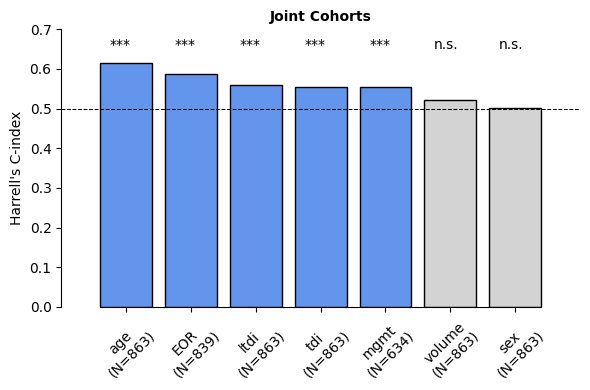

In [26]:
covariates = ["sex", "age", "ltdi", "tdi", "volume", "mgmt", "EOR"]
data = DATA[covariates+["site","OS","status"]]

fig, ax = plt.subplots(1,1, figsize=(6,4))
level_CI = 95
HarrellCindex = np.zeros((len(covariates),))
HarrellCindex_p = np.zeros((len(covariates),))
colors = []
samples = []
for i in range(0,len(covariates)):
    data_notna = data[[covariates[i],"site","OS","status"]].dropna()
    samples.append(len(data_notna))

    # Model including site covariate
    OS_STATS = np.array([(st, oss) for st,oss in zip(data_notna["status"],data_notna["OS"])], dtype=[('event', 'bool'),('time', '<f4')])
    Cmodel_site = CoxPHSurvivalAnalysis(n_iter=200)
    Cmodel_site.fit(data_notna[[covariates[i],"site"]].values,OS_STATS)
    site_effect = Cmodel_site.coef_[-1]

    # Excluding the effect of site
    OS_STATS = np.array(
        [(st, ovs) for st, ovs in zip(data_notna["status"].values==1, data_notna["OS"].values*np.exp(site_effect*data_notna["site"]))],
        dtype=[('event', 'bool'),('time', 'float')]
    )
    Cmodel = CoxPHSurvivalAnalysis(n_iter=200)
    Cmodel.fit(data_notna[covariates[i]].values.reshape(-1, 1),OS_STATS)
    HarrellCindex[i] = Cmodel.score(data_notna[covariates[i]].values.reshape(-1, 1),OS_STATS)

    # Permutation test for the model without site effect
    pop = []
    for _ in tqdm(range(n_perms), desc=f"Cox feature selection for the covariate {covariates[i]}"):
        perm_OS_STATS = np.random.permutation(OS_STATS)
        p_Cmodel = CoxPHSurvivalAnalysis()
        p_Cmodel.fit(data_notna[covariates[i]].values.reshape(-1, 1),perm_OS_STATS)
        pop.append(p_Cmodel.score(data_notna[covariates[i]].values.reshape(-1, 1),perm_OS_STATS))
    HarrellCindex_p[i] = np.mean(np.array(pop) >= HarrellCindex[i])
    if HarrellCindex_p[i]<=0.001:
        colors.append("cornflowerblue")
    elif HarrellCindex_p[i]<=0.01:
        colors.append("cornflowerblue")
    elif HarrellCindex_p[i]<=0.05:
        colors.append("cornflowerblue")
    else:            
        colors.append("lightgray")
    # Summary
    print(f"\tFeature: {covariates[i]} with a c-index of {HarrellCindex[i]} (p={HarrellCindex_p[i]})")
ax.bar(
    range(0,len(covariates)), 
    np.sort(HarrellCindex)[::-1],
    edgecolor="black",
    color=[colors[ii] for ii in np.argsort(HarrellCindex)[::-1]]
)
for ii, pval in enumerate(HarrellCindex_p[np.argsort(HarrellCindex)[::-1]]):
    if pval<=0.001:
        ax.text(ii-.25, .65, '***', color='black',fontsize=10, transform=ax.transData)
    elif pval<=0.01:
        ax.text(ii-.25, .65, '**', color='black',fontsize=10, transform=ax.transData)
    elif pval<=0.05:
        ax.text(ii-.25, .65, '*', color='black',fontsize=10, transform=ax.transData)
    else:            
        ax.text(ii-.25, .65, 'n.s.', color='black',fontsize=10, transform=ax.transData)
ax.hlines(0.5, -1, len(covariates), color='black', linewidth=.75, linestyle='--')
ax.spines[["top","right"]].set_visible(False)
ax.set_ylabel("Harrell's C-index")
ax.set_ylim([0,0.7])
ax.set_xlim([-1,len(covariates)])
ax.set_xticks(range(0,len(covariates)))
ax.set_xticklabels([f"{covariates[ii]}\n(N={samples[ii]})" for ii in np.argsort(HarrellCindex)[::-1]], rotation=45)
ax.spines['bottom'].set_bounds(-.4,len(covariates)-.6)
ax.spines['left'].set_bounds(0,.7)
ax.set_title("Joint Cohorts", fontsize=10, fontweight='bold')

fig.tight_layout()
fig.savefig(os.path.join(figs_folder, f"Feature-importance.{fmt}"), dpi=dpi, format=fmt)

### Feature selection

Select K features workflow: 100%|██████████| 50/50 [1:13:56<00:00, 88.72s/it]


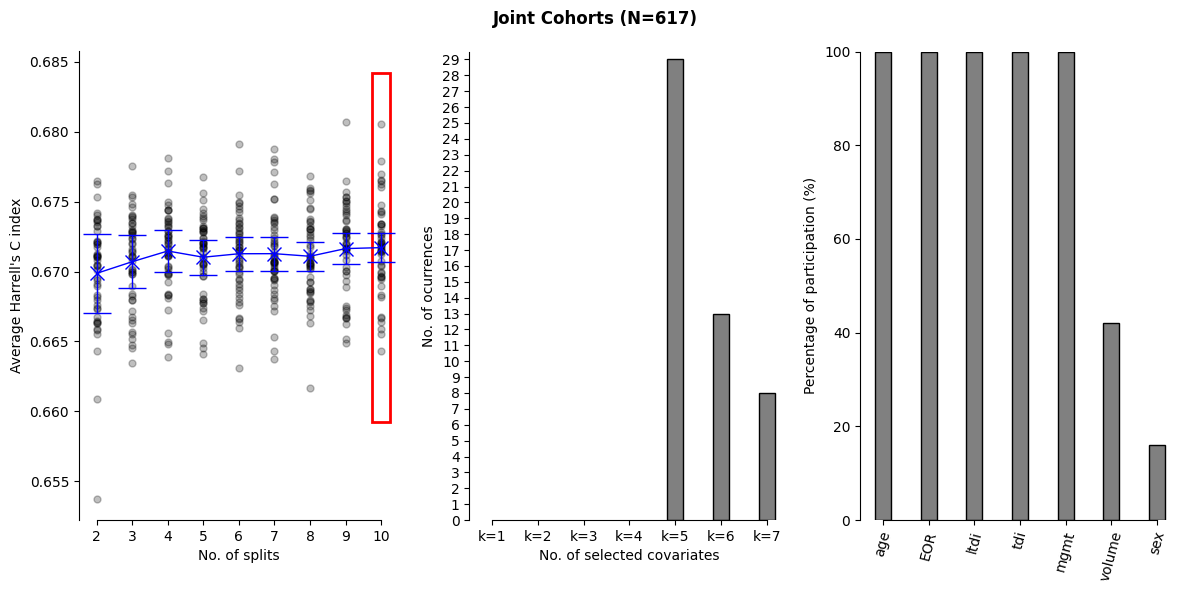

In [27]:
def Harrell_C_index(X, y):
    n_features = X.shape[1]
    Cscores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        Cscores[j] = m.score(Xj, y)
    return Cscores

pipe = Pipeline(
    [
        ("select", SelectKBest(Harrell_C_index)),
        ("model", CoxPHSurvivalAnalysis()),
    ]
)
splits = range(2,11) # 10
runs = 50 # 50

# Features to consider in the order determined by their respective importances (execute cell above)
covariates = ["sex", "age", "ltdi", "tdi", "volume", "mgmt", "EOR"]
covariates = [covariates[ii] for ii in np.argsort(HarrellCindex)[::-1]]
data = DATA[covariates+["site","OS","status"]].dropna()

# Removing the effect of site to run the selection workflow
pre_model = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = pre_model.fit()
site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 
OS_STATS = np.array([(st, oss) for st,oss in zip(data["status"],data["OS"])], dtype=[('event', 'bool'),('time', '<f4')])
features = data[covariates]

# Feature selection workflow
param_grid = {"select__k": np.arange(1, len(covariates)+1)}
mean_test = np.zeros((runs, len(splits)))
k_best_results = np.zeros((runs, len(splits)))
fig, ax = plt.subplots(1,3, figsize=(12,6))
for tt in tqdm(range(runs), desc=f"Select K features workflow"):
    for i, spl in enumerate(splits):
        cv = KFold(n_splits=spl, shuffle=True, random_state=None) # Assign a given random state if you want to ensure reproducibility
        gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
        gcv.fit(features, OS_STATS)        
        results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
        mean_test[tt,i] = results["mean_test_score"].values.max()
        k_best_results[tt,i] = results["param_select__k"].values[0]
        ax[0].plot(spl, mean_test[tt,i], 'o', color='black', alpha=0.25, markersize=5)


best_split = splits[mean_test.mean(axis=0).argmax()]-2
k_feat, feature_counts = np.unique(k_best_results[:,best_split], return_counts=True)
ax[0].errorbar(splits, mean_test.mean(axis=0), yerr=mean_test.std(axis=0)/np.sqrt(splits), linestyle='-', color='blue', linewidth=1, fmt='x',markersize=10, capsize=10)
rect = patches.Rectangle((best_split+1.75, mean_test.mean(axis=0).max()-.0125), 0.5, 0.025, linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
ax[0].spines[["top","right"]].set_visible(False)
ax[0].set_xticks(splits)
ax[0].set_xticklabels(splits)
ax[0].set_xlim([splits[0]-.5, splits[-1]+.5])
ax[0].set_xlabel("No. of splits")
ax[0].set_ylabel("Average Harrell's C index")
ax[0].spines['bottom'].set_bounds(splits[0], splits[-1])
ax[1].bar(
    k_feat, 
    feature_counts,
    edgecolor="black",
    color="gray",
    width=.35
)
ax[1].spines[["top","right"]].set_visible(False)
ax[1].set_xlim([.5,features.shape[-1]+.5])
ax[1].set_xticks(range(1,features.shape[-1]+1))
ax[1].set_xticklabels([f"k={ii}" for ii in range(1,features.shape[-1]+1)])
ax[1].set_ylabel("No. of ocurrences")
ax[1].set_xlabel("No. of selected covariates")
ax[1].spines['bottom'].set_bounds(1,features.shape[-1])
ax[1].set_ylim([0, max(feature_counts)+.5])
ax[1].set_yticks(range(0,max(feature_counts)+1))
ax[1].set_yticklabels(range(0,max(feature_counts)+1))
feature_participation = np.zeros((len(covariates),)) # Same order as in labels
for i in range(len(k_feat)):
    k_fs = int(k_feat[i])
    for j in range(k_fs):
        feature_participation[j] += feature_counts[i]

ax[2].bar(
    range(1,features.shape[-1]+1), 
    100*feature_participation/runs,
    edgecolor="black",
    color="gray",
    width=.35
)
ax[2].spines[["top","right"]].set_visible(False)
ax[2].set_xlim([.5,features.shape[-1]+.5])
ax[2].set_xticks(range(1,features.shape[-1]+1))
ax[2].set_xticklabels(covariates, rotation=75)
ax[2].set_ylabel("Percentage of participation (%)")
ax[2].spines['bottom'].set_bounds(1,features.shape[-1])
ax[2].set_ylim([0, 100])
ax[2].set_yticks([0,20,40,60,80,100])
ax[2].set_yticklabels([0,20,40,60,80,100])

fig.suptitle(f"Joint Cohorts (N={len(data)})", fontsize=12, fontweight='bold')
fig.tight_layout()
fig.savefig(os.path.join(figs_folder, f"Feature-selection.{fmt}"), dpi=dpi, format=fmt)

## Missing value strategy &\to& ??

# Logistic regressions

## Death at 6 months

### Including the L-TDI covariate

In [28]:
covariates = ["sex", "age", "ltdi", "mgmt", "EOR"]
data = DATA[covariates+["site", "OS", "status"]].dropna()

# We remove the effect of site
pre_model = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = pre_model.fit()
site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

## We discard right censoring before the cutoff
cutoff = 6 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_LTDI_6 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.428130
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  584
Model:                          Logit   Df Residuals:                      578
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1370
Time:                        17:51:00   Log-Likelihood:                -250.03
converged:                       True   LL-Null:                       -289.72
Covariance Type:            nonrobust   LLR p-value:                 1.127e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5769      0.928     -3.853      0.000      -5.397      -1.757
sex           -0.2107      0.

### Including the TDI covariate

In [29]:
covariates = ["sex", "age", "tdi", "mgmt", "EOR"]
data = DATA[covariates+["site", "OS", "status"]].dropna()

# We remove the effect of site
pre_model = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = pre_model.fit()
site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

## We discard right censoring before the cutoff
cutoff = 6 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_6 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.429961
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  584
Model:                          Logit   Df Residuals:                      578
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1333
Time:                        17:51:00   Log-Likelihood:                -251.10
converged:                       True   LL-Null:                       -289.72
Covariance Type:            nonrobust   LLR p-value:                 3.153e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4993      0.942     -3.713      0.000      -5.346      -1.652
sex           -0.2082      0.

### Including the TDI and volume as covariates

In [30]:
covariates = ["sex", "age", "tdi", "volume", "mgmt", "EOR"]
data = DATA[covariates+["site", "OS", "status"]].dropna()

# We remove the effect of site
pre_model = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = pre_model.fit()
site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

## We discard right censoring before the cutoff
cutoff = 6 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_volume_6 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.429260
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  584
Model:                          Logit   Df Residuals:                      577
Method:                           MLE   Df Model:                            6
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1347
Time:                        17:51:00   Log-Likelihood:                -250.69
converged:                       True   LL-Null:                       -289.72
Covariance Type:            nonrobust   LLR p-value:                 8.945e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6954      0.973     -3.798      0.000      -5.602      -1.788
sex           -0.2121      0.

### Excluding tract density-based covariates

In [31]:
covariates = ["sex", "age", "mgmt", "EOR"]
data = DATA[covariates+["site", "OS", "status"]].dropna()

# We remove the effect of site
pre_model = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = pre_model.fit()
site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

## We discard right censoring before the cutoff
cutoff = 6 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_without_6 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.431917
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  584
Model:                          Logit   Df Residuals:                      579
Method:                           MLE   Df Model:                            4
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1294
Time:                        17:51:00   Log-Likelihood:                -252.24
converged:                       True   LL-Null:                       -289.72
Covariance Type:            nonrobust   LLR p-value:                 2.026e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0058      0.878     -3.422      0.001      -4.727      -1.284
sex           -0.1636      0.

## Death at 12 months

### Including the L-TDI covariate

In [32]:
covariates = ["sex", "age", "ltdi", "mgmt", "EOR"]
data = DATA[covariates+["site", "OS", "status"]].dropna()

# We remove the effect of site
pre_model = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = pre_model.fit()
site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

## We discard right censoring before the cutoff
cutoff = 12 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_LTDI_12 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.561549
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  546
Model:                          Logit   Df Residuals:                      540
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1550
Time:                        17:51:00   Log-Likelihood:                -306.61
converged:                       True   LL-Null:                       -362.83
Covariance Type:            nonrobust   LLR p-value:                 1.241e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5277      0.773     -1.976      0.048      -3.043      -0.013
sex           -0.1230      0.

### Including the TDI covariate

In [33]:
covariates = ["sex", "age", "tdi", "mgmt", "EOR"]
data = DATA[covariates+["site", "OS", "status"]].dropna()

# We remove the effect of site
pre_model = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = pre_model.fit()
site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

## We discard right censoring before the cutoff
cutoff = 12 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_12 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.572887
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  546
Model:                          Logit   Df Residuals:                      540
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1379
Time:                        17:51:00   Log-Likelihood:                -312.80
converged:                       True   LL-Null:                       -362.83
Covariance Type:            nonrobust   LLR p-value:                 5.102e-20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1045      0.778     -1.419      0.156      -2.630       0.421
sex           -0.1225      0.

### Including the TDI and volume covariates

In [34]:
covariates = ["sex", "age", "tdi", "volume", "mgmt", "EOR"]
data = DATA[covariates+["site", "OS", "status"]].dropna()

# We remove the effect of site
pre_model = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = pre_model.fit()
site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

## We discard right censoring before the cutoff
cutoff = 12 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_volume_12 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.563602
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  546
Model:                          Logit   Df Residuals:                      539
Method:                           MLE   Df Model:                            6
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1519
Time:                        17:51:00   Log-Likelihood:                -307.73
converged:                       True   LL-Null:                       -362.83
Covariance Type:            nonrobust   LLR p-value:                 1.841e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6310      0.808     -2.019      0.043      -3.214      -0.048
sex           -0.1088      0.

### Excluding tract density-based covariates

In [35]:
covariates = ["sex", "age", "mgmt", "EOR"]
data = DATA[covariates+["site", "OS", "status"]].dropna()

# We remove the effect of site
pre_model = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = pre_model.fit()
site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

## We discard right censoring before the cutoff
cutoff = 12 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_without_12 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.575798
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  546
Model:                          Logit   Df Residuals:                      541
Method:                           MLE   Df Model:                            4
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1335
Time:                        17:51:00   Log-Likelihood:                -314.39
converged:                       True   LL-Null:                       -362.83
Covariance Type:            nonrobust   LLR p-value:                 4.507e-20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6189      0.722     -0.857      0.392      -2.035       0.797
sex           -0.0948      0.

## Death at 18 months

### Including the L-TDI covariate

In [36]:
covariates = ["sex", "age", "ltdi", "mgmt", "EOR"]
data = DATA[covariates+["site", "OS", "status"]].dropna()

# We remove the effect of site
pre_model = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = pre_model.fit()
site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

## We discard right censoring before the cutoff
cutoff = 18 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_LTDI_18 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.582162
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  526
Model:                          Logit   Df Residuals:                      520
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1458
Time:                        17:51:00   Log-Likelihood:                -306.22
converged:                       True   LL-Null:                       -358.49
Covariance Type:            nonrobust   LLR p-value:                 5.822e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0012      0.766      1.306      0.191      -0.501       2.503
sex           -0.2025      0.

### Including the TDI covariate

In [37]:
covariates = ["sex", "age", "tdi", "mgmt", "EOR"]
data = DATA[covariates+["site", "OS", "status"]].dropna()

# We remove the effect of site
pre_model = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = pre_model.fit()
site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

## We discard right censoring before the cutoff
cutoff = 18 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_18 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.583747
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  526
Model:                          Logit   Df Residuals:                      520
Method:                           MLE   Df Model:                            5
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1396
Time:                        17:51:01   Log-Likelihood:                -307.05
converged:                       True   LL-Null:                       -356.86
Covariance Type:            nonrobust   LLR p-value:                 6.374e-20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2224      0.786      1.556      0.120      -0.317       2.762
sex           -0.2255      0.

### Including the TDI and volume covariates

In [38]:
covariates = ["sex", "age", "tdi", "volume", "mgmt", "EOR"]
data = DATA[covariates+["site", "OS", "status"]].dropna()

# We remove the effect of site
pre_model = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = pre_model.fit()
site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

## We discard right censoring before the cutoff
cutoff = 18 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_TDI_volume_18 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.584518
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  526
Model:                          Logit   Df Residuals:                      519
Method:                           MLE   Df Model:                            6
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1408
Time:                        17:51:01   Log-Likelihood:                -307.46
converged:                       True   LL-Null:                       -357.86
Covariance Type:            nonrobust   LLR p-value:                 1.704e-19
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0688      0.792      1.350      0.177      -0.483       2.621
sex           -0.1939      0.

### Excluding tract density-based covariates

In [39]:
covariates = ["sex", "age", "mgmt", "EOR"]
data = DATA[covariates+["site", "OS", "status"]].dropna()

# We remove the effect of site
pre_model = PHReg(
    data["OS"],
    data[covariates+["site"]],
    status=data["status"]
)
results_site = pre_model.fit()
site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

## We discard right censoring before the cutoff
cutoff = 18 * daysXmonth
mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
mask_alive = data["OS"]>cutoff
data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

# Fit the logistic model
data_log = data[covariates+["died"]].dropna()
X = sm.add_constant(data_log[covariates])
logit_model = sm.Logit(data_log["died"], X)
results_log = logit_model.fit()
LR_without_18 = results_log.llf
print(results_log.summary())

Optimization terminated successfully.
         Current function value: 0.586427
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  526
Model:                          Logit   Df Residuals:                      521
Method:                           MLE   Df Model:                            4
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                  0.1356
Time:                        17:51:01   Log-Likelihood:                -308.46
converged:                       True   LL-Null:                       -356.86
Covariance Type:            nonrobust   LLR p-value:                 4.732e-20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6596      0.740      2.242      0.025       0.209       3.110
sex           -0.2020      0.

## Comparisson through Log-likelihood ratios

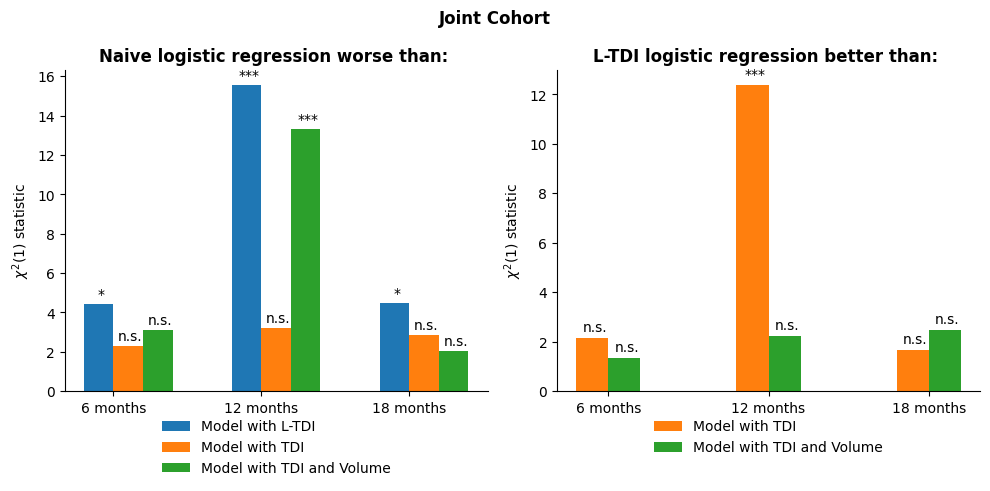

In [40]:
def get_significance_marker(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"  
    elif p < 0.05:
        return "*"  
    else:
        return "n.s." 
    
fig, ax = plt.subplots(1,2,figsize=(10, 5))
bar_width = 0.2
time_labels = ["6 months", "12 months", "18 months"]
x = np.arange(len(time_labels))

### Measuring the added value of tract density-based covariates
model_labels = ["Model with L-TDI", "Model with TDI", "Model with TDI and Volume"]
colors = ["tab:blue", "tab:orange", "tab:green"]
llrs = -2*np.array([
    [LR_LTDI_6-LR_without_6, LR_TDI_6-LR_without_6, LR_TDI_volume_6-LR_without_6],
    [LR_LTDI_12-LR_without_12, LR_TDI_12-LR_without_12, LR_TDI_volume_12-LR_without_12],
    [LR_LTDI_18-LR_without_18, LR_TDI_18-LR_without_18, LR_TDI_volume_18-LR_without_18]
])
llrs = - llrs ## We want to see the increase in LR when adding covariates!!
p_values = 1 - chi2.cdf(llrs, df=1)
for i in range(len(model_labels)):
    bars = ax[0].bar(x + i * bar_width, llrs[:, i], width=bar_width, label=model_labels[i], color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = get_significance_marker(p_values[j, i])
        ax[0].text(
            bar.get_x() + bar.get_width() / 2 + 0.015,
            height + 0.15, 
            significance,
            ha="center", va="bottom", fontsize=10
        )

ax[0].spines[["top","right"]].set_visible(False)
ax[0].set_xticks(x + bar_width/2, time_labels)
ax[0].set_ylabel(r'$\chi^2(1)$'+" statistic")
ax[0].legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax[0].set_title("Naive logistic regression worse than: ", fontweight='bold', fontsize=12)

### L-TDI against the other two models
model_labels = ["Model with TDI", "Model with TDI and Volume"]
colors = ["tab:orange", "tab:green"]
llrs = -2*np.array([
    [LR_TDI_6-LR_LTDI_6, LR_TDI_volume_6-LR_LTDI_6],
    [LR_TDI_12-LR_LTDI_12, LR_TDI_volume_12-LR_LTDI_12],
    [LR_TDI_18-LR_LTDI_18, LR_TDI_volume_18-LR_LTDI_18]
])
p_values = 1 - chi2.cdf(llrs, df=1)
for i in range(len(model_labels)):
    bars = ax[1].bar(x + i * bar_width, llrs[:, i], width=bar_width, label=model_labels[i], color=colors[i])
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = get_significance_marker(p_values[j, i])
        ax[1].text(
            bar.get_x() + bar.get_width() / 2 + 0.015,  
            height + 0.15,  
            significance,
            ha="center", va="bottom", fontsize=10
        )

ax[1].spines[["top","right"]].set_visible(False)
ax[1].set_xticks(x + bar_width/2, time_labels)
ax[1].set_ylabel(r'$\chi^2(1)$'+" statistic")
ax[1].legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.05))
ax[1].set_title("L-TDI logistic regression better than: ", fontweight='bold', fontsize=12)

fig.suptitle(f"Joint Cohort", fontsize=12, fontweight='bold')
fig.tight_layout()
fig.savefig(os.path.join(figs_folder, f"Logistic-regression.{fmt}"), dpi=dpi, format=fmt)

## Prediction of death

### L-TDI trained on UCSF

In [41]:
for cutoff in [6 * daysXmonth, 12 * daysXmonth, 18 * daysXmonth]:
    print(f"PREDICTING DEATH BEAFORE {int(cutoff/daysXmonth)} MONTHS")
    covariates = ["sex", "age", "ltdi", "mgmt", "EOR"]
    data = DATA[covariates+["site", "OS", "status"]].dropna()

    # We remove the effect of site
    pre_model = PHReg(
        data["OS"],
        data[covariates+["site"]],
        status=data["status"]
    )
    results_site = pre_model.fit()
    site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
    data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

    mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
    mask_alive = data["OS"]>cutoff
    data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

    train_ucsf = data.loc[data["site"]==0, covariates+["died"]].dropna()
    test_upenn = data.loc[data["site"]==1, covariates+["died"]].dropna()

    random_state = 42
    use_stratified = True 
    lam = 0.5
    scores_to_record = ["roc_auc", "balanced_accuracy"]

    param_grid = {
        "n_splits": range(2,12),  # Try different number of folds
        "n_repeats": range(5,25)  # Try different repetitions
    }

    best_score = -np.inf
    best_params = None
    best_scores = {}

    for n_splits in tqdm(param_grid["n_splits"], desc="Number of splits"):
        for n_repeats in param_grid["n_repeats"]:
            if use_stratified:
                cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
            else:
                cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

            logistic_model = LogisticRegression(max_iter=200)
            scores = cross_validate(
                logistic_model, 
                train_ucsf[covariates], 
                train_ucsf["died"], 
                cv=cv, 
                scoring=scores_to_record
            )
            mean_cost = 0.5*( lam * scores["test_roc_auc"].mean() + (1-lam) * scores["test_balanced_accuracy"].mean() )

            if mean_cost > best_score:
                best_score = mean_cost
                best_params = {"n_splits": n_splits, "n_repeats": n_repeats}
                best_scores = {sc: (scores[f"test_{sc}"].mean(), scores[f"test_{sc}"].std() / np.sqrt(len(scores[f"test_{sc}"]))) for sc in scores_to_record}

    # Print best results
    print(f"Best parameters: {best_params}")
    for sc, (mean, sem) in best_scores.items():
        print(f"Best Mean ± SEM for {sc}: {mean:.4f} ± {sem:.4f}")
    print("++++++++++++++++++++++++++++++++++++")

    # Retrain the model with the best combination of parameters
    print(f"Retraining the model with the best parameters: {best_params}")
    if use_stratified:
        final_cv = RepeatedStratifiedKFold(
            n_splits=best_params["n_splits"], 
            n_repeats=best_params["n_repeats"], 
            random_state=random_state
        )
    else:
        final_cv = RepeatedKFold(
            n_splits=best_params["n_splits"], 
            n_repeats=best_params["n_repeats"], 
            random_state=random_state
        )
    final_model = LogisticRegression(max_iter=200)
    final_model.fit(
        train_ucsf[covariates], 
        train_ucsf["died"]
    )
    print("++++++++++++++++++++++++++++++++++++")

    # Test on the independent dataset   
    X_test = test_upenn[covariates]
    y_test = test_upenn["died"]     
    y_prob = final_model.predict_proba(X_test)[:, 1]  # Get probability for class 1
    y_pred = final_model.predict(X_test)              # Get binary predictions
    roc_auc = roc_auc_score(y_test, y_prob)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Test ROC AUC: {roc_auc:.4f}")
    print(f"Test Balanced Accuracy: {balanced_acc:.4f}")
    print("\n\n")

PREDICTING DEATH BEAFORE 6 MONTHS


Number of splits: 100%|██████████| 10/10 [02:02<00:00, 12.25s/it]


Best parameters: {'n_splits': 6, 'n_repeats': 7}
Best Mean ± SEM for roc_auc: 0.7658 ± 0.0102
Best Mean ± SEM for balanced_accuracy: 0.6164 ± 0.0092
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 6, 'n_repeats': 7}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7090
Test Balanced Accuracy: 0.5099



PREDICTING DEATH BEAFORE 12 MONTHS


Number of splits: 100%|██████████| 10/10 [01:51<00:00, 11.17s/it]


Best parameters: {'n_splits': 5, 'n_repeats': 5}
Best Mean ± SEM for roc_auc: 0.7601 ± 0.0092
Best Mean ± SEM for balanced_accuracy: 0.6735 ± 0.0110
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 5, 'n_repeats': 5}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7327
Test Balanced Accuracy: 0.6753



PREDICTING DEATH BEAFORE 18 MONTHS


Number of splits: 100%|██████████| 10/10 [01:52<00:00, 11.25s/it]

Best parameters: {'n_splits': 7, 'n_repeats': 8}
Best Mean ± SEM for roc_auc: 0.7487 ± 0.0099
Best Mean ± SEM for balanced_accuracy: 0.6696 ± 0.0100
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 7, 'n_repeats': 8}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7292
Test Balanced Accuracy: 0.6640





### L-TDI trained on UPENN

In [42]:
for cutoff in [6 * daysXmonth, 12 * daysXmonth, 18 * daysXmonth]:
    print(f"PREDICTING DEATH BEAFORE {int(cutoff/daysXmonth)} MONTHS")
    covariates = ["sex", "age", "ltdi", "mgmt", "EOR"]
    data = DATA[covariates+["site", "OS", "status"]].dropna()

    # We remove the effect of site
    pre_model = PHReg(
        data["OS"],
        data[covariates+["site"]],
        status=data["status"]
    )
    results_site = pre_model.fit()
    site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
    data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

    mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
    mask_alive = data["OS"]>cutoff
    data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

    train_upenn = data.loc[data["site"]==1, covariates+["died"]].dropna()
    test_ucsf = data.loc[data["site"]==0, covariates+["died"]].dropna()

    random_state = 42
    use_stratified = True 
    lam = 0.5
    scores_to_record = ["roc_auc", "balanced_accuracy"]

    param_grid = {
        "n_splits": range(2,12),  # Try different number of folds
        "n_repeats": range(5,25)  # Try different repetitions
    }

    best_score = -np.inf
    best_params = None
    best_scores = {}

    for n_splits in tqdm(param_grid["n_splits"], desc="Number of splits"):
        for n_repeats in param_grid["n_repeats"]:
            if use_stratified:
                cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
            else:
                cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

            logistic_model = LogisticRegression(max_iter=200)
            scores = cross_validate(
                logistic_model, 
                train_upenn[covariates], 
                train_upenn["died"], 
                cv=cv, 
                scoring=scores_to_record
            )
            mean_cost = 0.5*( lam * scores["test_roc_auc"].mean() + (1-lam) * scores["test_balanced_accuracy"].mean() )

            if mean_cost > best_score:
                best_score = mean_cost
                best_params = {"n_splits": n_splits, "n_repeats": n_repeats}
                best_scores = {sc: (scores[f"test_{sc}"].mean(), scores[f"test_{sc}"].std() / np.sqrt(len(scores[f"test_{sc}"]))) for sc in scores_to_record}

    # Print best results
    print(f"Best parameters: {best_params}")
    for sc, (mean, sem) in best_scores.items():
        print(f"Best Mean ± SEM for {sc}: {mean:.4f} ± {sem:.4f}")
    print("++++++++++++++++++++++++++++++++++++")

    # Retrain the model with the best combination of parameters
    print(f"Retraining the model with the best parameters: {best_params}")
    if use_stratified:
        final_cv = RepeatedStratifiedKFold(
            n_splits=best_params["n_splits"], 
            n_repeats=best_params["n_repeats"], 
            random_state=random_state
        )
    else:
        final_cv = RepeatedKFold(
            n_splits=best_params["n_splits"], 
            n_repeats=best_params["n_repeats"], 
            random_state=random_state
        )
    final_model = LogisticRegression(max_iter=200)
    final_model.fit(
        train_upenn[covariates], 
        train_upenn["died"]
    )
    print("++++++++++++++++++++++++++++++++++++")

    # Test on the independent dataset   
    X_test = test_ucsf[covariates]
    y_test = test_ucsf["died"]     
    y_prob = final_model.predict_proba(X_test)[:, 1]  # Get probability for class 1
    y_pred = final_model.predict(X_test)              # Get binary predictions
    roc_auc = roc_auc_score(y_test, y_prob)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Test ROC AUC: {roc_auc:.4f}")
    print(f"Test Balanced Accuracy: {balanced_acc:.4f}")
    print("\n\n")

PREDICTING DEATH BEAFORE 6 MONTHS


Number of splits: 100%|██████████| 10/10 [01:53<00:00, 11.31s/it]


Best parameters: {'n_splits': 6, 'n_repeats': 5}
Best Mean ± SEM for roc_auc: 0.7137 ± 0.0134
Best Mean ± SEM for balanced_accuracy: 0.5536 ± 0.0100
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 6, 'n_repeats': 5}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7376
Test Balanced Accuracy: 0.5902



PREDICTING DEATH BEAFORE 12 MONTHS


Number of splits: 100%|██████████| 10/10 [01:52<00:00, 11.26s/it]


Best parameters: {'n_splits': 2, 'n_repeats': 12}
Best Mean ± SEM for roc_auc: 0.7422 ± 0.0047
Best Mean ± SEM for balanced_accuracy: 0.6628 ± 0.0051
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 2, 'n_repeats': 12}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7433
Test Balanced Accuracy: 0.6498



PREDICTING DEATH BEAFORE 18 MONTHS


Number of splits: 100%|██████████| 10/10 [01:49<00:00, 10.95s/it]

Best parameters: {'n_splits': 7, 'n_repeats': 6}
Best Mean ± SEM for roc_auc: 0.7496 ± 0.0107
Best Mean ± SEM for balanced_accuracy: 0.6902 ± 0.0092
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 7, 'n_repeats': 6}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7387
Test Balanced Accuracy: 0.6799





### TDI trained on UCSF

In [43]:
for cutoff in [6 * daysXmonth, 12 * daysXmonth, 18 * daysXmonth]:
    print(f"PREDICTING DEATH BEAFORE {int(cutoff/daysXmonth)} MONTHS")
    covariates = ["sex", "age", "tdi", "mgmt", "EOR"]
    data = DATA[covariates+["site", "OS", "status"]].dropna()

    # We remove the effect of site
    pre_model = PHReg(
        data["OS"],
        data[covariates+["site"]],
        status=data["status"]
    )
    results_site = pre_model.fit()
    site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
    data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

    mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
    mask_alive = data["OS"]>cutoff
    data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

    train_ucsf = data.loc[data["site"]==0, covariates+["died"]].dropna()
    test_upenn = data.loc[data["site"]==1, covariates+["died"]].dropna()

    random_state = 42
    use_stratified = True 
    lam = 0.5
    scores_to_record = ["roc_auc", "balanced_accuracy"]

    param_grid = {
        "n_splits": range(2,12),  # Try different number of folds
        "n_repeats": range(5,25)  # Try different repetitions
    }

    best_score = -np.inf
    best_params = None
    best_scores = {}

    for n_splits in tqdm(param_grid["n_splits"], desc="Number of splits"):
        for n_repeats in param_grid["n_repeats"]:
            if use_stratified:
                cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
            else:
                cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

            logistic_model = LogisticRegression(max_iter=200)
            scores = cross_validate(
                logistic_model, 
                train_ucsf[covariates], 
                train_ucsf["died"], 
                cv=cv, 
                scoring=scores_to_record
            )
            mean_cost = 0.5*( lam * scores["test_roc_auc"].mean() + (1-lam) * scores["test_balanced_accuracy"].mean() )

            if mean_cost > best_score:
                best_score = mean_cost
                best_params = {"n_splits": n_splits, "n_repeats": n_repeats}
                best_scores = {sc: (scores[f"test_{sc}"].mean(), scores[f"test_{sc}"].std() / np.sqrt(len(scores[f"test_{sc}"]))) for sc in scores_to_record}

    # Print best results
    print(f"Best parameters: {best_params}")
    for sc, (mean, sem) in best_scores.items():
        print(f"Best Mean ± SEM for {sc}: {mean:.4f} ± {sem:.4f}")
    print("++++++++++++++++++++++++++++++++++++")

    # Retrain the model with the best combination of parameters
    print(f"Retraining the model with the best parameters: {best_params}")
    if use_stratified:
        final_cv = RepeatedStratifiedKFold(
            n_splits=best_params["n_splits"], 
            n_repeats=best_params["n_repeats"], 
            random_state=random_state
        )
    else:
        final_cv = RepeatedKFold(
            n_splits=best_params["n_splits"], 
            n_repeats=best_params["n_repeats"], 
            random_state=random_state
        )
    final_model = LogisticRegression(max_iter=200)
    final_model.fit(
        train_ucsf[covariates], 
        train_ucsf["died"]
    )
    print("++++++++++++++++++++++++++++++++++++")

    # Test on the independent dataset   
    X_test = test_upenn[covariates]
    y_test = test_upenn["died"]     
    y_prob = final_model.predict_proba(X_test)[:, 1]  # Get probability for class 1
    y_pred = final_model.predict(X_test)              # Get binary predictions
    roc_auc = roc_auc_score(y_test, y_prob)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Test ROC AUC: {roc_auc:.4f}")
    print(f"Test Balanced Accuracy: {balanced_acc:.4f}")
    print("\n\n")

PREDICTING DEATH BEAFORE 6 MONTHS


Number of splits: 100%|██████████| 10/10 [02:01<00:00, 12.18s/it]


Best parameters: {'n_splits': 6, 'n_repeats': 6}
Best Mean ± SEM for roc_auc: 0.7535 ± 0.0113
Best Mean ± SEM for balanced_accuracy: 0.6189 ± 0.0099
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 6, 'n_repeats': 6}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.6970
Test Balanced Accuracy: 0.5444



PREDICTING DEATH BEAFORE 12 MONTHS


Number of splits: 100%|██████████| 10/10 [01:58<00:00, 11.89s/it]


Best parameters: {'n_splits': 9, 'n_repeats': 12}
Best Mean ± SEM for roc_auc: 0.7495 ± 0.0069
Best Mean ± SEM for balanced_accuracy: 0.6570 ± 0.0066
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 9, 'n_repeats': 12}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7039
Test Balanced Accuracy: 0.6560



PREDICTING DEATH BEAFORE 18 MONTHS


Number of splits: 100%|██████████| 10/10 [01:59<00:00, 12.00s/it]

Best parameters: {'n_splits': 4, 'n_repeats': 5}
Best Mean ± SEM for roc_auc: 0.7447 ± 0.0105
Best Mean ± SEM for balanced_accuracy: 0.6670 ± 0.0090
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 4, 'n_repeats': 5}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7090
Test Balanced Accuracy: 0.6475





### TDI trained on UPENN

In [44]:
for cutoff in [6 * daysXmonth, 12 * daysXmonth, 18 * daysXmonth]:
    print(f"PREDICTING DEATH BEAFORE {int(cutoff/daysXmonth)} MONTHS")
    covariates = ["sex", "age", "tdi", "mgmt", "EOR"]
    data = DATA[covariates+["site", "OS", "status"]].dropna()

    # We remove the effect of site
    pre_model = PHReg(
        data["OS"],
        data[covariates+["site"]],
        status=data["status"]
    )
    results_site = pre_model.fit()
    site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
    data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

    mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
    mask_alive = data["OS"]>cutoff
    data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

    train_upenn = data.loc[data["site"]==1, covariates+["died"]].dropna()
    test_ucsf = data.loc[data["site"]==0, covariates+["died"]].dropna()

    random_state = 42
    use_stratified = True 
    lam = 0.5
    scores_to_record = ["roc_auc", "balanced_accuracy"]

    param_grid = {
        "n_splits": range(2,12),  # Try different number of folds
        "n_repeats": range(5,25)  # Try different repetitions
    }

    best_score = -np.inf
    best_params = None
    best_scores = {}

    for n_splits in tqdm(param_grid["n_splits"], desc="Number of splits"):
        for n_repeats in param_grid["n_repeats"]:
            if use_stratified:
                cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
            else:
                cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

            logistic_model = LogisticRegression(max_iter=200)
            scores = cross_validate(
                logistic_model, 
                train_upenn[covariates], 
                train_upenn["died"], 
                cv=cv, 
                scoring=scores_to_record
            )
            mean_cost = 0.5*( lam * scores["test_roc_auc"].mean() + (1-lam) * scores["test_balanced_accuracy"].mean() )

            if mean_cost > best_score:
                best_score = mean_cost
                best_params = {"n_splits": n_splits, "n_repeats": n_repeats}
                best_scores = {sc: (scores[f"test_{sc}"].mean(), scores[f"test_{sc}"].std() / np.sqrt(len(scores[f"test_{sc}"]))) for sc in scores_to_record}

    # Print best results
    print(f"Best parameters: {best_params}")
    for sc, (mean, sem) in best_scores.items():
        print(f"Best Mean ± SEM for {sc}: {mean:.4f} ± {sem:.4f}")
    print("++++++++++++++++++++++++++++++++++++")

    # Retrain the model with the best combination of parameters
    print(f"Retraining the model with the best parameters: {best_params}")
    if use_stratified:
        final_cv = RepeatedStratifiedKFold(
            n_splits=best_params["n_splits"], 
            n_repeats=best_params["n_repeats"], 
            random_state=random_state
        )
    else:
        final_cv = RepeatedKFold(
            n_splits=best_params["n_splits"], 
            n_repeats=best_params["n_repeats"], 
            random_state=random_state
        )
    final_model = LogisticRegression(max_iter=200)
    final_model.fit(
        train_upenn[covariates], 
        train_upenn["died"]
    )
    print("++++++++++++++++++++++++++++++++++++")

    # Test on the independent dataset   
    X_test = test_ucsf[covariates]
    y_test = test_ucsf["died"]     
    y_prob = final_model.predict_proba(X_test)[:, 1]  # Get probability for class 1
    y_pred = final_model.predict(X_test)              # Get binary predictions
    roc_auc = roc_auc_score(y_test, y_prob)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Test ROC AUC: {roc_auc:.4f}")
    print(f"Test Balanced Accuracy: {balanced_acc:.4f}")
    print("\n\n")

PREDICTING DEATH BEAFORE 6 MONTHS


Number of splits: 100%|██████████| 10/10 [02:01<00:00, 12.18s/it]


Best parameters: {'n_splits': 2, 'n_repeats': 5}
Best Mean ± SEM for roc_auc: 0.7316 ± 0.0064
Best Mean ± SEM for balanced_accuracy: 0.5782 ± 0.0100
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 2, 'n_repeats': 5}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7237
Test Balanced Accuracy: 0.5357



PREDICTING DEATH BEAFORE 12 MONTHS


Number of splits: 100%|██████████| 10/10 [02:01<00:00, 12.16s/it]


Best parameters: {'n_splits': 3, 'n_repeats': 11}
Best Mean ± SEM for roc_auc: 0.7342 ± 0.0063
Best Mean ± SEM for balanced_accuracy: 0.6698 ± 0.0061
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 3, 'n_repeats': 11}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7088
Test Balanced Accuracy: 0.6463



PREDICTING DEATH BEAFORE 18 MONTHS


Number of splits: 100%|██████████| 10/10 [01:59<00:00, 11.96s/it]

Best parameters: {'n_splits': 3, 'n_repeats': 5}
Best Mean ± SEM for roc_auc: 0.7458 ± 0.0090
Best Mean ± SEM for balanced_accuracy: 0.6665 ± 0.0094
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 3, 'n_repeats': 5}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7153
Test Balanced Accuracy: 0.6338





### Trained on UCSF

In [45]:
for cutoff in [6 * daysXmonth, 12 * daysXmonth, 18 * daysXmonth]:
    print(f"PREDICTING DEATH BEAFORE {int(cutoff/daysXmonth)} MONTHS")
    covariates = ["sex", "age", "mgmt", "EOR"]
    data = DATA[covariates+["site", "OS", "status"]].dropna()

    # We remove the effect of site
    pre_model = PHReg(
        data["OS"],
        data[covariates+["site"]],
        status=data["status"]
    )
    results_site = pre_model.fit()
    site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
    data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 

    mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
    mask_alive = data["OS"]>cutoff
    data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

    train_ucsf = data.loc[data["site"]==0, covariates+["died"]].dropna()
    test_upenn = data.loc[data["site"]==1, covariates+["died"]].dropna()

    random_state = 42
    use_stratified = True 
    lam = 0.5
    scores_to_record = ["roc_auc", "balanced_accuracy"]

    param_grid = {
        "n_splits": range(2,12),  # Try different number of folds
        "n_repeats": range(5,25)  # Try different repetitions
    }

    best_score = -np.inf
    best_params = None
    best_scores = {}

    for n_splits in tqdm(param_grid["n_splits"], desc="Number of splits"):
        for n_repeats in param_grid["n_repeats"]:
            if use_stratified:
                cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
            else:
                cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

            logistic_model = LogisticRegression(max_iter=200)
            scores = cross_validate(
                logistic_model, 
                train_ucsf[covariates], 
                train_ucsf["died"], 
                cv=cv, 
                scoring=scores_to_record
            )
            mean_cost = 0.5*( lam * scores["test_roc_auc"].mean() + (1-lam) * scores["test_balanced_accuracy"].mean() )

            if mean_cost > best_score:
                best_score = mean_cost
                best_params = {"n_splits": n_splits, "n_repeats": n_repeats}
                best_scores = {sc: (scores[f"test_{sc}"].mean(), scores[f"test_{sc}"].std() / np.sqrt(len(scores[f"test_{sc}"]))) for sc in scores_to_record}

    # Print best results
    print(f"Best parameters: {best_params}")
    for sc, (mean, sem) in best_scores.items():
        print(f"Best Mean ± SEM for {sc}: {mean:.4f} ± {sem:.4f}")
    print("++++++++++++++++++++++++++++++++++++")

    # Retrain the model with the best combination of parameters
    print(f"Retraining the model with the best parameters: {best_params}")
    if use_stratified:
        final_cv = RepeatedStratifiedKFold(
            n_splits=best_params["n_splits"], 
            n_repeats=best_params["n_repeats"], 
            random_state=random_state
        )
    else:
        final_cv = RepeatedKFold(
            n_splits=best_params["n_splits"], 
            n_repeats=best_params["n_repeats"], 
            random_state=random_state
        )
    final_model = LogisticRegression(max_iter=200)
    final_model.fit(
        train_ucsf[covariates], 
        train_ucsf["died"]
    )
    print("++++++++++++++++++++++++++++++++++++")

    # Test on the independent dataset   
    X_test = test_upenn[covariates]
    y_test = test_upenn["died"]     
    y_prob = final_model.predict_proba(X_test)[:, 1]  # Get probability for class 1
    y_pred = final_model.predict(X_test)              # Get binary predictions
    roc_auc = roc_auc_score(y_test, y_prob)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Test ROC AUC: {roc_auc:.4f}")
    print(f"Test Balanced Accuracy: {balanced_acc:.4f}")
    print("\n\n")

PREDICTING DEATH BEAFORE 6 MONTHS


Number of splits: 100%|██████████| 10/10 [01:50<00:00, 11.06s/it]


Best parameters: {'n_splits': 8, 'n_repeats': 9}
Best Mean ± SEM for roc_auc: 0.7576 ± 0.0114
Best Mean ± SEM for balanced_accuracy: 0.6196 ± 0.0100
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 8, 'n_repeats': 9}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7018
Test Balanced Accuracy: 0.5444



PREDICTING DEATH BEAFORE 12 MONTHS


Number of splits: 100%|██████████| 10/10 [01:42<00:00, 10.25s/it]


Best parameters: {'n_splits': 3, 'n_repeats': 11}
Best Mean ± SEM for roc_auc: 0.7494 ± 0.0063
Best Mean ± SEM for balanced_accuracy: 0.6627 ± 0.0061
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 3, 'n_repeats': 11}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7077
Test Balanced Accuracy: 0.6661



PREDICTING DEATH BEAFORE 18 MONTHS


Number of splits: 100%|██████████| 10/10 [01:42<00:00, 10.25s/it]

Best parameters: {'n_splits': 4, 'n_repeats': 14}
Best Mean ± SEM for roc_auc: 0.7507 ± 0.0069
Best Mean ± SEM for balanced_accuracy: 0.6692 ± 0.0067
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 4, 'n_repeats': 14}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7168
Test Balanced Accuracy: 0.6679





### Trained on UPENN

In [46]:
for cutoff in [6 * daysXmonth, 12 * daysXmonth, 18 * daysXmonth]:
    print(f"PREDICTING DEATH BEAFORE {int(cutoff/daysXmonth)} MONTHS")
    covariates = ["sex", "age", "mgmt", "EOR"]
    data = DATA[covariates+["site", "OS", "status"]].dropna()

    # We remove the effect of site
    pre_model = PHReg(
        data["OS"],
        data[covariates+["site"]],
        status=data["status"]
    )
    results_site = pre_model.fit()
    site_effect = results_site.params[np.array(pre_model.exog_names)=='site']
    data["OS"] = data["OS"] * np.exp(site_effect*data["site"]) 


    mask_died = (data["OS"]<=cutoff) * (data["status"]==1)
    mask_alive = data["OS"]>cutoff
    data.loc[:, "died"] = np.where(mask_died, 1, np.where(mask_alive, 0, np.nan))

    train_upenn = data.loc[data["site"]==1, covariates+["died"]].dropna()
    test_ucsf = data.loc[data["site"]==0, covariates+["died"]].dropna()

    random_state = 42
    use_stratified = True 
    lam = 0.5
    scores_to_record = ["roc_auc", "balanced_accuracy"]

    param_grid = {
        "n_splits": range(2,12),  # Try different number of folds
        "n_repeats": range(5,25)  # Try different repetitions
    }

    best_score = -np.inf
    best_params = None
    best_scores = {}

    for n_splits in tqdm(param_grid["n_splits"], desc="Number of splits"):
        for n_repeats in param_grid["n_repeats"]:
            if use_stratified:
                cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
            else:
                cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

            logistic_model = LogisticRegression(max_iter=200)
            scores = cross_validate(
                logistic_model, 
                train_upenn[covariates], 
                train_upenn["died"], 
                cv=cv, 
                scoring=scores_to_record
            )
            mean_cost = 0.5*( lam * scores["test_roc_auc"].mean() + (1-lam) * scores["test_balanced_accuracy"].mean() )

            if mean_cost > best_score:
                best_score = mean_cost
                best_params = {"n_splits": n_splits, "n_repeats": n_repeats}
                best_scores = {sc: (scores[f"test_{sc}"].mean(), scores[f"test_{sc}"].std() / np.sqrt(len(scores[f"test_{sc}"]))) for sc in scores_to_record}

    # Print best results
    print(f"Best parameters: {best_params}")
    for sc, (mean, sem) in best_scores.items():
        print(f"Best Mean ± SEM for {sc}: {mean:.4f} ± {sem:.4f}")
    print("++++++++++++++++++++++++++++++++++++")

    # Retrain the model with the best combination of parameters
    print(f"Retraining the model with the best parameters: {best_params}")
    if use_stratified:
        final_cv = RepeatedStratifiedKFold(
            n_splits=best_params["n_splits"], 
            n_repeats=best_params["n_repeats"], 
            random_state=random_state
        )
    else:
        final_cv = RepeatedKFold(
            n_splits=best_params["n_splits"], 
            n_repeats=best_params["n_repeats"], 
            random_state=random_state
        )
    final_model = LogisticRegression(max_iter=200)
    final_model.fit(
        train_upenn[covariates], 
        train_upenn["died"]
    )
    print("++++++++++++++++++++++++++++++++++++")

    # Test on the independent dataset   
    X_test = test_ucsf[covariates]
    y_test = test_ucsf["died"]     
    y_prob = final_model.predict_proba(X_test)[:, 1]  # Get probability for class 1
    y_pred = final_model.predict(X_test)              # Get binary predictions
    roc_auc = roc_auc_score(y_test, y_prob)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Test ROC AUC: {roc_auc:.4f}")
    print(f"Test Balanced Accuracy: {balanced_acc:.4f}")
    print("\n\n")

PREDICTING DEATH BEAFORE 6 MONTHS


Number of splits: 100%|██████████| 10/10 [01:42<00:00, 10.30s/it]


Best parameters: {'n_splits': 6, 'n_repeats': 5}
Best Mean ± SEM for roc_auc: 0.7171 ± 0.0129
Best Mean ± SEM for balanced_accuracy: 0.5462 ± 0.0085
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 6, 'n_repeats': 5}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7305
Test Balanced Accuracy: 0.5864



PREDICTING DEATH BEAFORE 12 MONTHS


Number of splits: 100%|██████████| 10/10 [01:39<00:00,  9.92s/it]


Best parameters: {'n_splits': 10, 'n_repeats': 23}
Best Mean ± SEM for roc_auc: 0.7199 ± 0.0061
Best Mean ± SEM for balanced_accuracy: 0.6606 ± 0.0055
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 10, 'n_repeats': 23}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7220
Test Balanced Accuracy: 0.6418



PREDICTING DEATH BEAFORE 18 MONTHS


Number of splits: 100%|██████████| 10/10 [01:39<00:00,  9.97s/it]

Best parameters: {'n_splits': 2, 'n_repeats': 5}
Best Mean ± SEM for roc_auc: 0.7346 ± 0.0063
Best Mean ± SEM for balanced_accuracy: 0.6512 ± 0.0069
++++++++++++++++++++++++++++++++++++
Retraining the model with the best parameters: {'n_splits': 2, 'n_repeats': 5}
++++++++++++++++++++++++++++++++++++
Test ROC AUC: 0.7360
Test Balanced Accuracy: 0.6519



